# QLLM包使用指南

环境：qllm_eval

## 推理代码

In [ ]:
# 导入必要的模块
from qllm_eval.utils import build_model_and_enc
from qllm_eval.quantization.quant_wrapper import quantize_model
import torch

# 设置模型路径
model_path = "/root/autodl-tmp/models/chatglm3-6b"

# 加载模型和分词器
model, enc = build_model_and_enc(model_path, use_flash_attn=False, kv_bit=None, kv_group_size=None)

# 设置量化参数
class Args:
    def __init__(self):
        self.w_bit = 8
        self.w_group_size = 128
        self.a_bit = None
        self.a_group_size = None
        self.kv_bit = None
        self.kv_group_size = None

args = Args()

# 量化模型
quantized_model = quantize_model(model, args)

# 定义一个生成回复的函数
def generate_response(prompt):
    inputs = enc(prompt, return_tensors="pt").to(quantized_model.device)
    with torch.no_grad():
        outputs = quantized_model.generate(**inputs, max_length=2048)
    response = enc.decode(outputs[0], skip_special_tokens=True)
    return response

# 测试模型
prompt = "请介绍一下中国的长城。"
response = generate_response(prompt)
print(response)

## 参数获取代码

QLLM量化KVCache等参数，但是模型参数仍未fp16

In [ ]:
# 导入必要的模块
from qllm_eval.utils import build_model_and_enc
from qllm_eval.quantization.quant_wrapper import quantize_model
import torch

# 设置模型路径
model_path = "/root/autodl-tmp/models/chatglm3-6b"

# 加载模型和分词器
model, enc = build_model_and_enc(model_path, use_flash_attn=False, kv_bit=None, kv_group_size=None)

# 设置量化参数
class Args:
    def __init__(self):
        self.w_bit = 8
        self.w_group_size = 128
        self.a_bit = None
        self.a_group_size = None
        self.kv_bit = None
        self.kv_group_size = None

args = Args()

# 打印量化参数
print("Quantization parameters:")
print(f"w_bit: {args.w_bit}")
print(f"w_group_size: {args.w_group_size}")
print(f"a_bit: {args.a_bit}")
print(f"a_group_size: {args.a_group_size}")
print(f"kv_bit: {args.kv_bit}")
print(f"kv_group_size: {args.kv_group_size}")

# 量化模型
quantized_model = quantize_model(model, args)

# 获取并打印模型参数的数据类型
print("\nOriginal model parameter types:")
for name, param in model.named_parameters():
    print(f"{name}: {param.dtype}")

print("\nQuantized model parameter types:")
for name, param in quantized_model.named_parameters():
    print(f"{name}: {param.dtype}")

# 打印模型的总参数数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters in original model: {count_parameters(model)}")
print(f"Total parameters in quantized model: {count_parameters(quantized_model)}")

# 打印模型所在的设备
print(f"\nOriginal model device: {next(model.parameters()).device}")
print(f"Quantized model device: {next(quantized_model.parameters()).device}")

# 打印量化模型的结构
def print_model_structure(model, depth=0):
    for name, module in model.named_children():
        print('  ' * depth + f"{name}:")
        if list(module.children()):
            print_model_structure(module, depth + 1)
        else:
            print('  ' * (depth + 1) + f"{type(module).__name__}")

print("\nQuantized model structure:")
print_model_structure(quantized_model)

# 搜索非float16的权重
print("\nSearching for non-float16 weights:")
for name, param in quantized_model.named_parameters():
    if param.dtype != torch.float16:
        print(f"{name}: {param.dtype}")

# BitsAndBytes量化参数

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# 获取模型信息
def get_model_info(model):
    params_list = []
    total_params = 0
    total_params_non_trainable = 0
    for name, param in model.named_parameters():
        layer_name = name.split('.')[0]
        layer = dict(model.named_modules())[layer_name]
        layer_class = layer.__class__.__name__

        params_count = param.numel()
        trainable = param.requires_grad

        params_list.append({
            'tensor': name,
            'layer_class': layer_class,
            'shape': str(list(param.size())),
            'precision': str(param.dtype).split('.')[-1],
            'params_count': str(params_count),
            'trainable': str(trainable),
            'device': str(param.device)
        })

        total_params += params_count
        if not trainable:
            total_params_non_trainable += params_count

    total_params_trainable = total_params - total_params_non_trainable
    total_params_info = {
        'total_params': total_params,
        'total_params_trainable': total_params_trainable,
        'total_params_non_trainable': total_params_non_trainable
    }

    return total_params_info, params_list

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 量化模型
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,  # 启用 8 位加载
    bnb_8bit_use_double_quant=True,  # 可根据需要选择是否使用双重量化
    bnb_8bit_quant_type="nf8",  # 设置量化类型为 'nf8'（normalized float 8-bit）
    bnb_8bit_compute_dtype=torch.bfloat16  # 设置计算时使用的数据类型为 bfloat16
)

# Load base model
tokenizer = AutoTokenizer.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

# 获取模型信息
total_params_info, params_list = get_model_info(model)

# 打印每层的详细信息
print("\n每层的详细信息:")
for layer_info in params_list:
    print("-" * 50)
    for key, value in layer_info.items():
        print(f"{key}: {value}")

# 打印总参数量信息
print("\n总参数量信息:")
for key, value in total_params_info.items():
    print(f"{key}: {value}")

print("Analysis completed.")

### 打印int8数据类型的参数

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# 获取模型信息
def get_model_info(model):
    params_list = []
    total_params = 0
    total_params_non_trainable = 0
    total_int8_params = 0

    for name, param in model.named_parameters():
        layer_name = name.split('.')[0]
        layer = dict(model.named_modules())[layer_name]
        layer_class = layer.__class__.__name__

        params_count = param.numel()
        trainable = param.requires_grad

        if param.dtype == torch.int8:
            params_list.append({
                'tensor': name,
                'layer_class': layer_class,
                'shape': str(list(param.size())),
                'precision': str(param.dtype).split('.')[-1],
                'params_count': str(params_count),
                'trainable': str(trainable),
                'device': str(param.device)
            })
            total_int8_params += params_count

        total_params += params_count
        if not trainable:
            total_params_non_trainable += params_count

    total_params_trainable = total_params - total_params_non_trainable
    total_params_info = {
        'total_params': total_params,
        'total_params_trainable': total_params_trainable,
        'total_params_non_trainable': total_params_non_trainable,
        'total_int8_params': total_int8_params
    }

    return total_params_info, params_list

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 量化模型
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,  # 启用 8 位加载
    bnb_8bit_use_double_quant=True,  # 可根据需要选择是否使用双重量化
    bnb_8bit_quant_type="nf8",  # 设置量化类型为 'nf8'（normalized float 8-bit）
    bnb_8bit_compute_dtype=torch.bfloat16  # 设置计算时使用的数据类型为 bfloat16
)

# Load base model
tokenizer = AutoTokenizer.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

# 获取模型信息
total_params_info, params_list = get_model_info(model)

# 打印 int8 参数的详细信息
print("\nint8 参数的详细信息:")
for layer_info in params_list:
    print("-" * 50)
    for key, value in layer_info.items():
        print(f"{key}: {value}")

# 打印总参数量信息
print("\n总参数量信息:")
for key, value in total_params_info.items():
    print(f"{key}: {value}")

print("Analysis completed.")

# ECC实验

## 标准比特翻转（0-7）
- **类型 0-7**：在8位整数中翻转特定的第i位（0 ≤ i ≤ 7）。
- **额外开销**：0位
- **错误注入**：X = X ⊕ (1 << (7-i))
- **错误纠正**：不提供错误纠正

## 全位翻转（8）
- **类型 8**：8位整数中的任何一位都可能被翻转。
- **额外开销**：0位
- **错误注入**：对每一位独立应用翻转概率
- **错误纠正**：不提供错误纠正

## 汉明码（9）
- **类型 9**：使用汉明(12,8)码进行错误纠正。
- **额外开销**：4位（50%）
- **编码**：
  P1 = A ⊕ B ⊕ D ⊕ E ⊕ G
  P2 = A ⊕ C ⊕ D ⊕ F ⊕ G
  P3 = B ⊕ C ⊕ D ⊕ H
  P4 = E ⊕ F ⊕ G ⊕ H
- **错误注入**：对12位编码后的数据进行随机翻转
- **错误纠正**：
  1. 计算syndrome（S1, S2, S3, S4）
  2. 如果syndrome不为0，其值（1-12）指示出错位置
  3. 翻转对应位置的比特进行纠正

## 顶部3位的ECC（11）
- **类型 11**：使用2个校验位保护顶部3位。
- **额外开销**：2位（25%）
- **编码**：
  P1 = A ⊕ B （A、B分别是第7、6位）
  P2 = B ⊕ C （C是第5位）
- **错误注入**：对编码后的5位（2位校验位+3位数据）进行随机翻转
- **错误纠正**：
  1. 计算新的校验位：P1_new = A ⊕ B, P2_new = B ⊕ C
  2. 确定错误模式并纠正：
     如果 P1 ⊕ P1_new = 1 且 P2 ⊕ P2_new = 0，则 A = A ⊕ 1
     如果 P1 ⊕ P1_new = 1 且 P2 ⊕ P2_new = 1，则 B = B ⊕ 1
     如果 P1 ⊕ P1_new = 0 且 P2 ⊕ P2_new = 1，则 C = C ⊕ 1

## 增强型顶部3位ECC（12）
- **类型 12**：类型11的改进版本。
- **额外开销**：2位（25%）
- **编码**：
  P1 = A ⊕ B
  P2 = A ⊕ C
- **错误注入**：对编码后的5位进行随机翻转
- **错误纠正**：
  1. 计算新的校验位：P1_new = A ⊕ B, P2_new = A ⊕ C
  2. 确定错误模式并纠正：
     如果 P1 ⊕ P1_new = 1 且 P2 ⊕ P2_new = 1，则 A = A ⊕ 1
     如果 P1 ⊕ P1_new = 1 且 P2 ⊕ P2_new = 0，则 B = B ⊕ 1
     如果 P1 ⊕ P1_new = 0 且 P2 ⊕ P2_new = 1，则 C = C ⊕ 1
  3. 额外的A纠正逻辑：
     如果 (A ≠ B) 且 (A ≠ C) 且 (错误模式为01或10)，则 A = A ⊕ 1

## 基于异或的ECC（13）
- **类型 13**：使用第一位和第二位的异或作为校验位。
- **额外开销**：1.025位（12.5%校验位 + 0.025%计算得出的溢出位 开销）
- **编码**：
  1. 将输入X加64得到X'
  2. 提取X'的最高位作为溢出标志
  3. P = (X' >> 6) ⊕ ((X' >> 5) & 1)
  4. 编码结果 = (P << 7) | (X' & 0x7F)
- **错误注入**：对编码后的8位数据进行随机翻转
- **错误纠正**：
  1. 计算新的校验位：P_new = (X >> 6) ⊕ ((X >> 5) & 1)
  2. 如果 P ≠ P_new：
     如果 P = 0，则 X = X & 0x3F
     如果 P = 1，则 X = (X & 0x3F) | 0x40
  3. 将结果减64，根据溢出标志调整回原始范围


注：标准PPL测试需要使用opencompass


## 实验代码

此demo为简单地翻转实验DEMO


### 全模型批量处理实验

此代码需要较多显存，因为是整个模型批量处理的，此代码是最快的

备注：单4090操作6B模型会OOM

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

def reverse_bits_gpu(x):
    mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, 128], dtype=torch.uint8, device=x.device)
    return ((x.unsqueeze(-1) & mask) != 0).flip(-1).to(torch.uint8).mul(mask).sum(-1)

def process_int8_params(model):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.dtype == torch.int8:
                # 将 int8 转换为 uint8
                uint8_param = param.byte()
                
                # 对每个元素进行位翻转
                reversed_param = reverse_bits_gpu(uint8_param)
                
                # 将 uint8 转回 int8
                new_param = reversed_param.to(torch.int8)
                
                # 为参数重新赋值
                param.data.copy_(new_param)

# 获取模型信息
def get_model_info(model):
    params_list = []
    total_params = 0
    total_params_non_trainable = 0
    total_int8_params = 0

    for name, param in model.named_parameters():
        layer_name = name.split('.')[0]
        layer = dict(model.named_modules())[layer_name]
        layer_class = layer.__class__.__name__

        params_count = param.numel()
        trainable = param.requires_grad

        if param.dtype == torch.int8:
            params_list.append({
                'tensor': name,
                'layer_class': layer_class,
                'shape': str(list(param.size())),
                'precision': str(param.dtype).split('.')[-1],
                'params_count': str(params_count),
                'trainable': str(trainable),
                'device': str(param.device)
            })
            total_int8_params += params_count

        total_params += params_count
        if not trainable:
            total_params_non_trainable += params_count

    total_params_trainable = total_params - total_params_non_trainable
    total_params_info = {
        'total_params': total_params,
        'total_params_trainable': total_params_trainable,
        'total_params_non_trainable': total_params_non_trainable,
        'total_int8_params': total_int8_params
    }

    return total_params_info, params_list

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 量化模型
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_use_double_quant=True,
    bnb_8bit_quant_type="nf8",
    bnb_8bit_compute_dtype=torch.bfloat16
)

# Load base model
tokenizer = AutoTokenizer.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

# 处理 int8 参数
process_int8_params(model)

# 获取模型信息
total_params_info, params_list = get_model_info(model)

# 打印 int8 参数的详细信息
print("\nint8 参数的详细信息 (处理后):")
for layer_info in params_list:
    print("-" * 50)
    for key, value in layer_info.items():
        print(f"{key}: {value}")

# 打印总参数量信息
print("\n总参数量信息:")
for key, value in total_params_info.items():
    print(f"{key}: {value}")

print("Analysis and processing completed.")

#### 逐Layer模型批量处理实验


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

def reverse_bits_gpu(x):
    mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, 128], dtype=torch.uint8, device=x.device)
    return ((x.unsqueeze(-1) & mask) != 0).flip(-1).to(torch.uint8).mul(mask).sum(-1)

def process_int8_params_batch(model, batch_size=1000000, layers_to_process=None):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if layers_to_process and not any(layer in name for layer in layers_to_process):
                continue
            if param.dtype == torch.int8:
                # 将 int8 转换为 uint8
                uint8_param = param.byte()
                
                # 获取参数的原始形状
                original_shape = uint8_param.shape
                
                # 将参数展平
                flattened = uint8_param.view(-1)
                
                # 分批处理
                for i in range(0, flattened.numel(), batch_size):
                    batch = flattened[i:i+batch_size]
                    
                    # 对批次进行位翻转
                    reversed_batch = reverse_bits_gpu(batch)
                    
                    # 将处理后的批次放回原位置
                    flattened[i:i+batch_size] = reversed_batch
                
                # 将展平的张量恢复原始形状
                new_param = flattened.view(original_shape)
                
                # 将 uint8 转回 int8
                new_param = new_param.to(torch.int8)
                
                # 为参数重新赋值
                param.data.copy_(new_param)
                print(f"Processed parameter: {name}")

def get_model_info(model):
    params_list = []
    total_params = 0
    total_params_non_trainable = 0
    total_int8_params = 0

    for name, param in model.named_parameters():
        layer_name = name.split('.')[0]
        layer = dict(model.named_modules())[layer_name]
        layer_class = layer.__class__.__name__

        params_count = param.numel()
        trainable = param.requires_grad

        if param.dtype == torch.int8:
            params_list.append({
                'tensor': name,
                'layer_class': layer_class,
                'shape': str(list(param.size())),
                'precision': str(param.dtype).split('.')[-1],
                'params_count': str(params_count),
                'trainable': str(trainable),
                'device': str(param.device)
            })
            total_int8_params += params_count

        total_params += params_count
        if not trainable:
            total_params_non_trainable += params_count

    total_params_trainable = total_params - total_params_non_trainable
    total_params_info = {
        'total_params': total_params,
        'total_params_trainable': total_params_trainable,
        'total_params_non_trainable': total_params_non_trainable,
        'total_int8_params': total_int8_params
    }

    return total_params_info, params_list

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 量化模型
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_use_double_quant=True,
    bnb_8bit_quant_type="nf8",
    bnb_8bit_compute_dtype=torch.bfloat16
)

# Load base model
tokenizer = AutoTokenizer.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

# 分批处理 int8 参数
# 如果要处理特定层，可以传入 layers_to_process 参数，例如：
# process_int8_params_batch(model, batch_size=1000000, layers_to_process=['transformer.encoder.layers.0', 'transformer.encoder.layers.1'])
process_int8_params_batch(model, batch_size=1000000)

# 获取模型信息
total_params_info, params_list = get_model_info(model)

# 打印 int8 参数的详细信息
print("\nint8 参数的详细信息 (处理后):")
for layer_info in params_list:
    print("-" * 50)
    for key, value in layer_info.items():
        print(f"{key}: {value}")

# 打印总参数量信息
print("\n总参数量信息:")
for key, value in total_params_info.items():
    print(f"{key}: {value}")

print("Analysis and processing completed.")

### 按位翻转存储

In [ ]:
import copy
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import gc

def bit_flip(x, err_rate, err_type):
    mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, 128], dtype=torch.uint8, device=x.device)
    
    if err_type in range(8):  # 对应于8个比特位中的一个
        flip_mask = torch.rand(x.shape, device=x.device) < err_rate
        flip_bit = mask[err_type]
        return torch.where(flip_mask, x ^ flip_bit, x)
    elif err_type == 8:  # 所有位都可能翻转
        flip_mask = torch.rand(x.shape + (8,), device=x.device) < err_rate
        flipped = x.unsqueeze(-1) ^ mask.unsqueeze(0)
        return torch.where(flip_mask, flipped, x.unsqueeze(-1)).squeeze(-1).byte()
    else:
        raise ValueError("Invalid err_type. Must be 0-8.")

def process_int8_params_batch(model, err_rate, err_type, batch_size=1000000, layers_to_process=None):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if layers_to_process and not any(layer in name for layer in layers_to_process):
                continue
            if param.dtype == torch.int8:
                uint8_param = param.byte()
                original_shape = uint8_param.shape
                flattened = uint8_param.view(-1)
                
                for i in range(0, flattened.numel(), batch_size):
                    batch = flattened[i:i+batch_size]
                    flipped_batch = bit_flip(batch, err_rate, err_type)
                    
                    # 添加检查
                    if flipped_batch.shape != batch.shape:
                        raise ValueError(f"Shape mismatch: {flipped_batch.shape} vs {batch.shape}")
                    
                    flattened[i:i+batch_size] = flipped_batch
                
                new_param = flattened.view(original_shape).to(torch.int8)
                param.data.copy_(new_param)
                # print(f"Processed parameter: {name}")

def get_model_info(model):
    params_list = []
    total_params = 0
    total_params_non_trainable = 0
    total_int8_params = 0

    for name, param in model.named_parameters():
        layer_name = name.split('.')[0]
        layer = dict(model.named_modules())[layer_name]
        layer_class = layer.__class__.__name__

        params_count = param.numel()
        trainable = param.requires_grad

        if param.dtype == torch.int8:
            params_list.append({
                'tensor': name,
                'layer_class': layer_class,
                'shape': str(list(param.size())),
                'precision': str(param.dtype).split('.')[-1],
                'params_count': str(params_count),
                'trainable': str(trainable),
                'device': str(param.device)
            })
            total_int8_params += params_count

        total_params += params_count
        if not trainable:
            total_params_non_trainable += params_count

    total_params_trainable = total_params - total_params_non_trainable
    total_params_info = {
        'total_params': total_params,
        'total_params_trainable': total_params_trainable,
        'total_params_non_trainable': total_params_non_trainable,
        'total_int8_params': total_int8_params
    }

    return total_params_info, params_list

def evaluate_model(model, tokenizer):
    # 这里添加一个简单的评估函数
    prompt = "请用一句话总结人工智能的重要性。"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=100)
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Model response: {response}")
    # 这里可以添加更多的评估指标

def check_param_changes(model_before, model_after):
    changes = []
    total_params = 0
    changed_params = 0

    for (name1, param1), (name2, param2) in zip(model_before.named_parameters(), model_after.named_parameters()):
        if name1 != name2:
            raise ValueError(f"Parameter names do not match: {name1} vs {name2}")

        if param1.dtype == torch.int8:
            total_params += param1.numel()
            diff = (param1 != param2).sum().item()
            changed_params += diff
            if diff > 0:
                changes.append({
                    'name': name1,
                    'total': param1.numel(),
                    'changed': diff,
                    'percentage': (diff / param1.numel()) * 100
                })

    overall_change_percentage = (changed_params / total_params) * 100 if total_params > 0 else 0

    return changes, overall_change_percentage

def run_experiment(err_rate, err_type):
    print(f"Running experiment with ERR_Rate: {err_rate}, ERR_Type: {err_type}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    tokenizer = AutoTokenizer.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

    # 创建模型的深拷贝
    model_before = copy.deepcopy(model)

    process_int8_params_batch(model, err_rate, err_type, batch_size=1000000)

    # 检查参数变化
    changes, overall_change_percentage = check_param_changes(model_before, model)

    print("\n参数变化详情:")
    for change in changes:
        print(f"Layer: {change['name']}")
        print(f"  Total parameters: {change['total']}")
        print(f"  Changed parameters: {change['changed']}")
        print(f"  Change percentage: {change['percentage']:.2f}%")

    print(f"\n整体参数变化百分比: {overall_change_percentage:.2f}%")

    total_params_info, params_list = get_model_info(model)

    print("\nint8 参数的详细信息 (处理后):")
    for layer_info in params_list:
        print("-" * 50)
        for key, value in layer_info.items():
            print(f"{key}: {value}")

    print("\n总参数量信息:")
    for key, value in total_params_info.items():
        print(f"{key}: {value}")

    print("Evaluating model performance:")
    evaluate_model(model, tokenizer)

    print("Experiment completed.")

    # 清理内存
    del model
    del model_before
    torch.cuda.empty_cache()
    gc.collect()
# 主程序
if __name__ == "__main__":
    err_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
    err_types = range(9)  # 0-8

    for err_rate in err_rates:
        for err_type in err_types:
            run_experiment(err_rate, err_type)

#### 日志结果保存至本地版代码

此代码用于检验各个bit位发生错误注入多模型造成的性能影响

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import gc
import copy
import sys
import os
import traceback
import torch

# 重定向输出到文件
log_file = '/root/autodl-tmp/ECC/result/chatglm3-6B.txt'
os.makedirs(os.path.dirname(log_file), exist_ok=True)
sys.stdout = open(log_file, 'w')

def bit_flip(x, err_rate, err_type):
    device = x.device
    mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, 128], dtype=torch.uint8, device=device)
    
    if err_type in range(8):  # 对应于8个比特位中的一个
        flip_mask = (torch.rand(x.shape, device=device) < err_rate).bool()
        flip_bit = mask[7 - err_type]
        return torch.where(flip_mask, x ^ flip_bit, x)
    elif err_type == 8:  # 所有位都可能翻转
        flip_mask = (torch.rand(x.shape + (8,), device=device) < err_rate).bool()
        flipped = x.unsqueeze(-1) ^ mask
        return torch.where(flip_mask, flipped, x.unsqueeze(-1)).sum(dim=-1).byte()
    else:
        raise ValueError("Invalid err_type. Must be 0-8.")

def int_to_binary(x):
    return format(x, '08b')

def process_int8_params_batch(model, err_rate, err_type, batch_size=1000000, layers_to_process=None):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if layers_to_process and not any(layer in name for layer in layers_to_process):
                continue
            if param.dtype == torch.int8:
                uint8_param = param.byte()
                original_shape = uint8_param.shape
                flattened = uint8_param.view(-1)
                
                # 处理所有批次
                for i in range(0, flattened.numel(), batch_size):
                    batch = flattened[i:i+batch_size]
                    flipped_batch = bit_flip(batch, err_rate, err_type)
                    flattened[i:i+batch_size] = flipped_batch
                
                new_param = flattened.view(original_shape).to(torch.int8)
                param.data.copy_(new_param)
                # print(f"Processed parameter: {name}")

def get_model_info(model):
    params_list = []
    total_params = 0
    total_params_non_trainable = 0
    total_int8_params = 0

    for name, param in model.named_parameters():
        layer_name = name.split('.')[0]
        layer = dict(model.named_modules())[layer_name]
        layer_class = layer.__class__.__name__

        params_count = param.numel()
        trainable = param.requires_grad

        if param.dtype == torch.int8:
            params_list.append({
                'tensor': name,
                'layer_class': layer_class,
                'shape': str(list(param.size())),
                'precision': str(param.dtype).split('.')[-1],
                'params_count': str(params_count),
                'trainable': str(trainable),
                'device': str(param.device)
            })
            total_int8_params += params_count

        total_params += params_count
        if not trainable:
            total_params_non_trainable += params_count

    total_params_trainable = total_params - total_params_non_trainable
    total_params_info = {
        'total_params': total_params,
        'total_params_trainable': total_params_trainable,
        'total_params_non_trainable': total_params_non_trainable,
        'total_int8_params': total_int8_params
    }

    return total_params_info, params_list

def evaluate_model(model, tokenizer):
    prompt = "请用一句话总结人工智能的重要性。"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=100)
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Model response: {response}")

def check_param_changes(model_before, model_after):
    changes = []
    total_params = 0
    changed_params = 0

    for (name1, param1), (name2, param2) in zip(model_before.named_parameters(), model_after.named_parameters()):
        if name1 != name2:
            raise ValueError(f"Parameter names do not match: {name1} vs {name2}")

        if param1.dtype == torch.int8:
            total_params += param1.numel()
            diff = (param1 != param2).sum().item()
            changed_params += diff
            if diff > 0:
                changes.append({
                    'name': name1,
                    'total': param1.numel(),
                    'changed': diff,
                    'percentage': (diff / param1.numel()) * 100
                })

    overall_change_percentage = (changed_params / total_params) * 100 if total_params > 0 else 0

    return changes, overall_change_percentage

def run_experiment(err_rate, err_type):
    print(f"Running experiment with ERR_Rate: {err_rate}, ERR_Type: {err_type}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    tokenizer = AutoTokenizer.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained("/root/autodl-tmp/models/chatglm3-6b", quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

    # 创建模型的深拷贝
    model_before = copy.deepcopy(model)

    try:
        # 注入错误
        process_int8_params_batch(model, err_rate, err_type, batch_size=1000000)

        # 检查参数变化
        changes, overall_change_percentage = check_param_changes(model_before, model)
        # print(f"Overall change percentage: {overall_change_percentage:.6f}%")
        # for change in changes:
        #     print(f"Parameter: {change['name']}, Changed: {change['changed']}/{change['total']} ({change['percentage']:.6f}%)")

        print("Evaluating model performance after error injection:")
        evaluate_model(model, tokenizer)

        print("Experiment completed.")
    except Exception as e:
        print(f"Error occurred during experiment:")
        print(f"ERR_Rate: {err_rate}, ERR_Type: {err_type}")
        print(traceback.format_exc())
    finally:
        # 清理内存
        del model
        del model_before
        torch.cuda.empty_cache()
        gc.collect()

# 主程序
if __name__ == "__main__":
    err_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
    err_types = range(9)  # 0-8

    for i, err_rate in enumerate(err_rates):
        for j, err_type in enumerate(err_types):
            print('='*50)
            print(f"Starting experiment {i*len(err_types) + j + 1} of {len(err_rates)*len(err_types)}")
            run_experiment(err_rate, err_type)

# 关闭文件
sys.stdout.close()
# 恢复标准输出
sys.stdout = sys.__stdout__

### ECC校验恢复

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import gc
import copy
import sys
import os
import traceback
import torch
import csv
model_name = 'Qwen2-1.5B-Instruct'
model_path = '/root/autodl-tmp/models/' + model_name
# 重定向输出到文件
log_file = '/root/autodl-tmp/ECC/result/'+model_name+'.txt'
csv_file = '/root/autodl-tmp/ECC/result/'+model_name+'.csv'
os.makedirs(os.path.dirname(log_file), exist_ok=True)
os.makedirs(os.path.dirname(csv_file), exist_ok=True)
sys.stdout = open(log_file, 'w', encoding='utf-8')

def hamming_encode(data):
    p1 = data[:, 0] ^ data[:, 1] ^ data[:, 3] ^ data[:, 4] ^ data[:, 6]
    p2 = data[:, 0] ^ data[:, 2] ^ data[:, 3] ^ data[:, 5] ^ data[:, 6]
    p3 = data[:, 1] ^ data[:, 2] ^ data[:, 3] ^ data[:, 7]
    p4 = data[:, 4] ^ data[:, 5] ^ data[:, 6] ^ data[:, 7]
    return torch.stack([p1, p2, data[:, 0], p3, data[:, 1], data[:, 2], data[:, 3], 
                        p4, data[:, 4], data[:, 5], data[:, 6], data[:, 7]], dim=1)

def hamming_decode(encoded):
    s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4] ^ encoded[:, 6] ^ encoded[:, 8] ^ encoded[:, 10]
    s2 = encoded[:, 1] ^ encoded[:, 2] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 9] ^ encoded[:, 10]
    s3 = encoded[:, 3] ^ encoded[:, 4] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 11]
    s4 = encoded[:, 7] ^ encoded[:, 8] ^ encoded[:, 9] ^ encoded[:, 10] ^ encoded[:, 11]
    syndrome = s1 + 2*s2 + 4*s3 + 8*s4
    corrected = encoded.clone()

    error_masks = [syndrome == i for i in range(1, 13)]
    for i, mask in enumerate(error_masks):
        corrected[mask, i] = 1 - corrected[mask, i]

    return torch.stack([corrected[:, 2], corrected[:, 4], corrected[:, 5], corrected[:, 6],
                        corrected[:, 8], corrected[:, 9], corrected[:, 10], corrected[:, 11]], dim=1)

def bit_flip(x, err_rate, err_type):
    device = x.device
    mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, 128], dtype=torch.uint8, device=device)
    
    if err_type in range(8):  # 对应于8个比特位中的一个
        flip_mask = (torch.rand(x.shape, device=device) < err_rate).bool()
        flip_bit = mask[7 - err_type]
        flipped = torch.where(flip_mask, x ^ flip_bit, x)
        return flipped, flip_mask
    elif err_type == 8:  # 所有位都可能翻转
        flip_mask = (torch.rand(x.shape + (8,), device=device) < err_rate).bool()
        flipped = x.unsqueeze(-1) ^ mask
        flipped = torch.where(flip_mask, flipped, x.unsqueeze(-1)).sum(dim=-1).byte()
        return flipped, flip_mask.any(dim=-1)
    elif err_type == 9:  # ECC汉明码校验恢复
        data_bits = torch.zeros((x.shape[0], 8), dtype=torch.uint8, device=device)
        for i in range(8):
            data_bits[:, i] = (x >> i) & 1
        encoded = hamming_encode(data_bits)
        flip_mask = (torch.rand(encoded.shape, device=device) < err_rate).bool()
        flipped_encoded = encoded ^ flip_mask
        decoded_bits = hamming_decode(flipped_encoded)
        decoded = (decoded_bits * torch.tensor([1,2,4,8,16,32,64,128], dtype=torch.uint8, device=device)).sum(dim=1)
        return decoded, flip_mask.any(dim=1)
    else:
        raise ValueError("Invalid err_type. Must be 0-9.")

def int_to_binary(x):
    return format(x, '08b')

def process_int8_params_batch(model, err_rate, err_type, batch_size=1000000, layers_to_process=None):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if layers_to_process and not any(layer in name for layer in layers_to_process):
                continue
            if param.dtype == torch.int8:
                uint8_param = param.byte()
                original_shape = uint8_param.shape
                flattened = uint8_param.view(-1)
                
                batch = flattened[:batch_size]
                print(f"\nParameter: {name}")
                print("Original batch (first 10 elements, in binary):")
                for i in range(10):
                    print(f"{batch[i].item():3d}: {int_to_binary(batch[i].item())}")
                
                flipped_batch, flip_mask = bit_flip(batch, err_rate, err_type)
                
                print("\nFlipped batch (first 10 elements, in binary):")
                for i in range(10):
                    print(f"{flipped_batch[i].item():3d}: {int_to_binary(flipped_batch[i].item())}")
                
                num_flipped = flip_mask.sum().item()
                total_bits = batch.numel() * 8
                actual_flip_rate = num_flipped / total_bits
                print(f"\nNumber of flipped bits: {num_flipped}")
                print(f"Total bits: {total_bits}")
                print(f"Actual flip rate: {actual_flip_rate:.6f}")
                print(f"Target flip rate: {err_rate:.6f}")
                
                flattened[:batch_size] = flipped_batch
                
                new_param = flattened.view(original_shape).to(torch.int8)
                param.data.copy_(new_param)
                print(f"Processed parameter: {name}")

def get_model_info(model):
    params_list = []
    total_params = 0
    total_params_non_trainable = 0
    total_int8_params = 0

    for name, param in model.named_parameters():
        layer_name = name.split('.')[0]
        layer = dict(model.named_modules())[layer_name]
        layer_class = layer.__class__.__name__

        params_count = param.numel()
        trainable = param.requires_grad

        if param.dtype == torch.int8:
            params_list.append({
                'tensor': name,
                'layer_class': layer_class,
                'shape': str(list(param.size())),
                'precision': str(param.dtype).split('.')[-1],
                'params_count': str(params_count),
                'trainable': str(trainable),
                'device': str(param.device)
            })
            total_int8_params += params_count

        total_params += params_count
        if not trainable:
            total_params_non_trainable += params_count

    total_params_trainable = total_params - total_params_non_trainable
    total_params_info = {
        'total_params': total_params,
        'total_params_trainable': total_params_trainable,
        'total_params_non_trainable': total_params_non_trainable,
        'total_int8_params': total_int8_params
    }

    return total_params_info, params_list

def evaluate_model(model, tokenizer):
    prompt = "请用一句话总结人工智能的重要性。"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=100)
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Model response: {response}")
    return response

def check_param_changes(model_before, model_after):
    changes = []
    total_params = 0
    changed_params = 0

    for (name1, param1), (name2, param2) in zip(model_before.named_parameters(), model_after.named_parameters()):
        if name1 != name2:
            raise ValueError(f"Parameter names do not match: {name1} vs {name2}")

        if param1.dtype == torch.int8:
            total_params += param1.numel()
            diff = (param1 != param2).sum().item()
            changed_params += diff
            if diff > 0:
                changes.append({
                    'name': name1,
                    'total': param1.numel(),
                    'changed': diff,
                    'percentage': (diff / param1.numel()) * 100
                })

    overall_change_percentage = (changed_params / total_params) * 100 if total_params > 0 else 0

    return changes, overall_change_percentage

def run_experiment(err_rate, err_type):
    print(f"Running experiment with ERR_Rate: {err_rate}, ERR_Type: {err_type}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

    model_before = copy.deepcopy(model)

    try:
        process_int8_params_batch(model, err_rate, err_type, batch_size=1000000)

        changes, overall_change_percentage = check_param_changes(model_before, model)

        print("Evaluating model performance:")
        response = evaluate_model(model, tokenizer)  # 使用注入错误后的模型进行评估

        print("Experiment completed.")
        return overall_change_percentage, response, changes
    except Exception as e:
        print(f"Error occurred during experiment:")
        print(f"ERR_Rate: {err_rate}, ERR_Type: {err_type}")
        print(traceback.format_exc())
        return None, None, None
    finally:
        del model
        del model_before
        torch.cuda.empty_cache()
        gc.collect()

if __name__ == "__main__":
    err_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
    err_types = range(10)  # 0-9

    results = []

    for i, err_rate in enumerate(err_rates):
        for j, err_type in enumerate(err_types):
            print('='*50)
            print(f"Starting experiment {i*len(err_types) + j + 1} of {len(err_rates)*len(err_types)}")
            overall_change_percentage, response, changes = run_experiment(err_rate, err_type)
            results.append({
                'err_rate': err_rate,
                'err_type': err_type,
                'overall_change_percentage': overall_change_percentage,
                'response': response,
                'changes': changes
            })

    # 将结果写入CSV文件
    with open(csv_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['ERR_Rate', 'ERR_Type', 'Overall Change Percentage', 'Response'])
        for result in results:
            writer.writerow([
                result['err_rate'],
                result['err_type'],
                result['overall_change_percentage'],
                result['response']
            ])

    print("\n===== Overall Results =====")
    for result in results:
        print(f"ERR_Rate: {result['err_rate']}, ERR_Type: {result['err_type']}")
        print(f"Overall Change Percentage: {result['overall_change_percentage']:.4f}%")
        print(f"Model Response: {result['response']}")
        if result['changes']:
            print("Top 5 most changed parameters:")
            sorted_changes = sorted(result['changes'], key=lambda x: x['percentage'], reverse=True)
            for change in sorted_changes[:5]:
                print(f"  {change['name']}: {change['percentage']:.2f}% ({change['changed']} / {change['total']})")
        print("-" * 30)

sys.stdout.close()
sys.stdout = sys.__stdout__

### ECC校验恢复(8, 12)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import gc
import copy
import sys
import os
import traceback
import torch
import csv
model_names = ['Qwen2-1.5B-Instruct','Qwen2-0.5B-Instruct']
for model_name in model_names:

    model_path = '/root/autodl-tmp/models/' + model_name
    # 重定向输出到文件
    log_file = '/root/autodl-tmp/ECC/result/'+model_name+'.txt'
    csv_file = '/root/autodl-tmp/ECC/result/'+model_name+'.csv'
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)
    sys.stdout = open(log_file, 'w', encoding='utf-8')


    def int_to_binary(x):
        return format(x, '08b')
    
    def hamming_encode(data):
        p1 = data[:, 0] ^ data[:, 1] ^ data[:, 3] ^ data[:, 4] ^ data[:, 6]
        p2 = data[:, 0] ^ data[:, 2] ^ data[:, 3] ^ data[:, 5] ^ data[:, 6]
        p3 = data[:, 1] ^ data[:, 2] ^ data[:, 3] ^ data[:, 7]
        p4 = data[:, 4] ^ data[:, 5] ^ data[:, 6] ^ data[:, 7]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1], data[:, 2], data[:, 3], 
                            p4, data[:, 4], data[:, 5], data[:, 6], data[:, 7]], dim=1)

    def hamming_decode(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4] ^ encoded[:, 6] ^ encoded[:, 8] ^ encoded[:, 10]
        s2 = encoded[:, 1] ^ encoded[:, 2] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 9] ^ encoded[:, 10]
        s3 = encoded[:, 3] ^ encoded[:, 4] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 11]
        s4 = encoded[:, 7] ^ encoded[:, 8] ^ encoded[:, 9] ^ encoded[:, 10] ^ encoded[:, 11]
        syndrome = s1 + 2*s2 + 4*s3 + 8*s4
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 13)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4], corrected[:, 5], corrected[:, 6],
                            corrected[:, 8], corrected[:, 9], corrected[:, 10], corrected[:, 11]], dim=1)

    def bit_flip(x, err_rate, err_type):
        device = x.device
        mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, 128], dtype=torch.uint8, device=device)
        
        if err_type in range(8):  # 对应于8个比特位中的一个
            flip_mask = (torch.rand(x.shape, device=device) < err_rate).bool()
            flip_bit = mask[7 - err_type]
            flipped = torch.where(flip_mask, x ^ flip_bit, x)
            return flipped, flip_mask
        elif err_type == 8:  # 所有位都可能翻转
            flip_mask = (torch.rand(x.shape + (8,), device=device) < err_rate).bool()
            flipped = x.unsqueeze(-1) ^ mask
            flipped = torch.where(flip_mask, flipped, x.unsqueeze(-1)).sum(dim=-1).byte()
            return flipped, flip_mask.any(dim=-1)
        elif err_type == 9:  # ECC汉明码校验恢复（全部8位）
            data_bits = torch.zeros((x.shape[0], 8), dtype=torch.uint8, device=device)
            for i in range(8):
                data_bits[:, i] = (x >> i) & 1
            encoded = hamming_encode(data_bits)
            flip_mask = (torch.rand(encoded.shape, device=device) < err_rate).bool()
            flipped_encoded = encoded ^ flip_mask
            decoded_bits = hamming_decode(flipped_encoded)
            decoded = (decoded_bits * torch.tensor([1,2,4,8,16,32,64,128], dtype=torch.uint8, device=device)).sum(dim=1)
            return decoded, flip_mask.any(dim=1)
        else:
            raise ValueError("Invalid err_type. Must be 0-9.")


    def process_int8_params_batch(model, err_rate, err_type, batch_size=1000000, layers_to_process=None):
        with torch.no_grad():
            for name, param in model.named_parameters():
                if layers_to_process and not any(layer in name for layer in layers_to_process):
                    continue
                if param.dtype == torch.int8:
                    uint8_param = param.byte()
                    original_shape = uint8_param.shape
                    flattened = uint8_param.view(-1)
                    
                    batch = flattened[:batch_size]
                    flipped_batch, flip_mask = bit_flip(batch, err_rate, err_type)
                    
                    # 找出发生变化的元素
                    changed_indices = torch.where(batch != flipped_batch)[0]
                    num_changed = changed_indices.size(0)

                    if num_changed > 0:
                        print(f"\nParameter: {name}")
                        print(f"Number of changed elements: {num_changed}")
                        print("First 10 changed elements (original -> flipped):")
                        for i in range(min(10, num_changed)):
                            idx = changed_indices[i]
                            original = batch[idx].item()
                            flipped = flipped_batch[idx].item()
                            print(f"{original:3d}: {int_to_binary(original)} -> {flipped:3d}: {int_to_binary(flipped)}")

                    num_flipped = flip_mask.sum().item()
                    total_bits = batch.numel() * 8
                    actual_flip_rate = num_flipped / total_bits
                    print(f"\nNumber of flipped bits: {num_flipped}")
                    print(f"Total bits: {total_bits}")
                    print(f"Actual flip rate: {actual_flip_rate:.6f}")
                    print(f"Target flip rate: {err_rate:.6f}")
                    
                    flattened[:batch_size] = flipped_batch
                    
                    new_param = flattened.view(original_shape).to(torch.int8)
                    param.data.copy_(new_param)
                    print(f"Processed parameter: {name}")

    def get_model_info(model):
        params_list = []
        total_params = 0
        total_params_non_trainable = 0
        total_int8_params = 0

        for name, param in model.named_parameters():
            layer_name = name.split('.')[0]
            layer = dict(model.named_modules())[layer_name]
            layer_class = layer.__class__.__name__

            params_count = param.numel()
            trainable = param.requires_grad

            if param.dtype == torch.int8:
                params_list.append({
                    'tensor': name,
                    'layer_class': layer_class,
                    'shape': str(list(param.size())),
                    'precision': str(param.dtype).split('.')[-1],
                    'params_count': str(params_count),
                    'trainable': str(trainable),
                    'device': str(param.device)
                })
                total_int8_params += params_count

            total_params += params_count
            if not trainable:
                total_params_non_trainable += params_count

        total_params_trainable = total_params - total_params_non_trainable
        total_params_info = {
            'total_params': total_params,
            'total_params_trainable': total_params_trainable,
            'total_params_non_trainable': total_params_non_trainable,
            'total_int8_params': total_int8_params
        }

        return total_params_info, params_list

    def evaluate_model(model, tokenizer):
        prompt = "请用一句话总结人工智能的重要性。"
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            generated_ids = model.generate(
                model_inputs.input_ids,
                max_new_tokens=100
            )
        
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(f"Model response: {response}")
        return response

    def check_param_changes(model_before, model_after):
        changes = []
        total_params = 0
        changed_params = 0

        for (name1, param1), (name2, param2) in zip(model_before.named_parameters(), model_after.named_parameters()):
            if name1 != name2:
                raise ValueError(f"Parameter names do not match: {name1} vs {name2}")

            if param1.dtype == torch.int8:
                total_params += param1.numel()
                diff = (param1 != param2).sum().item()
                changed_params += diff
                if diff > 0:
                    changes.append({
                        'name': name1,
                        'total': param1.numel(),
                        'changed': diff,
                        'percentage': (diff / param1.numel()) * 100
                    })

        overall_change_percentage = (changed_params / total_params) * 100 if total_params > 0 else 0

        return changes, overall_change_percentage

    def run_experiment(err_rate, err_type):
        print(f"Running experiment with ERR_Rate: {err_rate}, ERR_Type: {err_type}")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_quant_type="nf8",
            bnb_8bit_compute_dtype=torch.bfloat16
        )

        tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

        model_before = copy.deepcopy(model)

        try:
            process_int8_params_batch(model, err_rate, err_type, batch_size=1000000)

            changes, overall_change_percentage = check_param_changes(model_before, model)

            print("Evaluating model performance:")
            response = evaluate_model(model, tokenizer)  # 使用注入错误后的模型进行评估

            print("Experiment completed.")
            return overall_change_percentage, response, changes
        except Exception as e:
            print(f"Error occurred during experiment:")
            print(f"ERR_Rate: {err_rate}, ERR_Type: {err_type}")
            print(traceback.format_exc())
            return None, None, None
        finally:
            del model
            del model_before
            torch.cuda.empty_cache()
            gc.collect()

    if __name__ == "__main__":
        err_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
        # err_types = range(10)  # 0-9
        err_types = [9]  # 0-9
        results = []

        for i, err_rate in enumerate(err_rates):
            for j, err_type in enumerate(err_types):
                print('='*50)
                print(f"Starting experiment {i*len(err_types) + j + 1} of {len(err_rates)*len(err_types)}")
                overall_change_percentage, response, changes = run_experiment(err_rate, err_type)
                results.append({
                    'err_rate': err_rate,
                    'err_type': err_type,
                    'overall_change_percentage': overall_change_percentage,
                    'response': response,
                    'changes': changes
                })

        # 将结果写入CSV文件
        with open(csv_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['ERR_Rate', 'ERR_Type', 'Overall Change Percentage', 'Response'])
            for result in results:
                writer.writerow([
                    result['err_rate'],
                    result['err_type'],
                    result['overall_change_percentage'],
                    result['response']
                ])

        print("\n===== Overall Results =====")
        for result in results:
            print(f"ERR_Rate: {result['err_rate']}, ERR_Type: {result['err_type']}")
            print(f"Overall Change Percentage: {result['overall_change_percentage']:.4f}%")
            print(f"Model Response: {result['response']}")
            if result['changes']:
                print("Top 5 most changed parameters:")
                sorted_changes = sorted(result['changes'], key=lambda x: x['percentage'], reverse=True)
                for change in sorted_changes[:5]:
                    print(f"  {change['name']}: {change['percentage']:.2f}% ({change['changed']} / {change['total']})")
            print("-" * 30)

    sys.stdout.close()
    sys.stdout = sys.__stdout__

### ECC纠正前两位（8，9）

1、2位异或->校验位

当校验值变化时，1、2位变为反码

完全无效，导致模型崩溃

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import gc
import copy
import sys
import os
import traceback
import torch
import csv
# model_names = ['Qwen2-1.5B-Instruct','Qwen2-0.5B-Instruct']
model_names = ['Qwen2-0.5B-Instruct']
for model_name in model_names:

    model_path = '/root/autodl-tmp/models/' + model_name
    # 重定向输出到文件
    log_file = '/root/autodl-tmp/ECC/result/'+model_name+'.txt'
    csv_file = '/root/autodl-tmp/ECC/result/'+model_name+'.csv'
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)
    sys.stdout = open(log_file, 'w', encoding='utf-8')


    def int_to_binary(x):
        return format(x, '08b')
    
    def hamming_encode(data):
        p1 = data[:, 0] ^ data[:, 1] ^ data[:, 3] ^ data[:, 4] ^ data[:, 6]
        p2 = data[:, 0] ^ data[:, 2] ^ data[:, 3] ^ data[:, 5] ^ data[:, 6]
        p3 = data[:, 1] ^ data[:, 2] ^ data[:, 3] ^ data[:, 7]
        p4 = data[:, 4] ^ data[:, 5] ^ data[:, 6] ^ data[:, 7]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1], data[:, 2], data[:, 3], 
                            p4, data[:, 4], data[:, 5], data[:, 6], data[:, 7]], dim=1)

    def hamming_decode(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4] ^ encoded[:, 6] ^ encoded[:, 8] ^ encoded[:, 10]
        s2 = encoded[:, 1] ^ encoded[:, 2] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 9] ^ encoded[:, 10]
        s3 = encoded[:, 3] ^ encoded[:, 4] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 11]
        s4 = encoded[:, 7] ^ encoded[:, 8] ^ encoded[:, 9] ^ encoded[:, 10] ^ encoded[:, 11]
        syndrome = s1 + 2*s2 + 4*s3 + 8*s4
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 13)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4], corrected[:, 5], corrected[:, 6],
                            corrected[:, 8], corrected[:, 9], corrected[:, 10], corrected[:, 11]], dim=1)

    def hamming_encode_2bits(data):
        p1 = data[:, 0] ^ data[:, 1]
        p2 = data[:, 0]
        p3 = data[:, 1]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1]], dim=1)

    def hamming_decode_2bits(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4]
        s2 = encoded[:, 1] ^ encoded[:, 2]
        s3 = encoded[:, 3] ^ encoded[:, 4]
        syndrome = s1 + 2*s2 + 4*s3
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 6)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4]], dim=1)

    def bit_flip(x, err_rate, err_type):
        device = x.device
        mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, 128], dtype=torch.uint8, device=device)
        
        if err_type in range(8):  # 对应于8个比特位中的一个
            flip_mask = (torch.rand(x.shape, device=device) < err_rate).bool()
            flip_bit = mask[7 - err_type]
            flipped = torch.where(flip_mask, x ^ flip_bit, x)
            return flipped, flip_mask, flipped
        elif err_type == 8:  # 所有位都可能翻转
            flip_mask = (torch.rand(x.shape + (8,), device=device) < err_rate).bool()
            flipped = x.unsqueeze(-1) ^ mask
            flipped = torch.where(flip_mask, flipped, x.unsqueeze(-1)).sum(dim=-1).byte()
            return flipped, flip_mask.any(dim=-1), flipped
        elif err_type == 9:  # ECC汉明码校验恢复（全部8位）
            data_bits = torch.zeros((x.shape[0], 8), dtype=torch.uint8, device=device)
            for i in range(8):
                data_bits[:, i] = (x >> i) & 1
            encoded = hamming_encode(data_bits)
            flip_mask = (torch.rand(encoded.shape, device=device) < err_rate).bool()
            flipped_encoded = encoded ^ flip_mask
            decoded_bits = hamming_decode(flipped_encoded)
            decoded = (decoded_bits * torch.tensor([1,2,4,8,16,32,64,128], dtype=torch.uint8, device=device)).sum(dim=1)
            flipped = (flipped_encoded[:, [2,4,5,6,8,9,10,11]] * torch.tensor([1,2,4,8,16,32,64,128], dtype=torch.uint8, device=device)).sum(dim=1)
            return decoded, flip_mask.any(dim=1), flipped
        elif err_type == 10:  # ECC汉明码校验恢复（仅前两位）
            # 提取前两位
            top_two_bits = (x >> 6) & 0b11

            # 编码
            p1 = top_two_bits ^ (top_two_bits >> 1)
            p2 = top_two_bits >> 1
            p3 = top_two_bits & 1
            encoded = (p1 << 2) | (p2 << 1) | p3

            # 随机翻转（只在编码位上）
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * torch.randint(0, 8, x.shape, device=device))

            # 解码
            s1 = (flipped_encoded >> 2) ^ (flipped_encoded >> 1) ^ (flipped_encoded & 1)
            s2 = (flipped_encoded >> 2) ^ (flipped_encoded >> 1)
            s3 = (flipped_encoded >> 2) ^ (flipped_encoded & 1)
            syndrome = (s1 << 2) | (s2 << 1) | s3

            # 错误校正
            corrected = flipped_encoded ^ syndrome

            # 只更新检测到错误的位
            new_top_two_bits = ((corrected >> 1) & 2) | (corrected & 1)
            changed_mask = new_top_two_bits != top_two_bits

            # 应用更正（直接在原始张量上操作）
            result = (x & 0b00111111) | (new_top_two_bits << 6)
            flipped = (x & 0b00111111) | (((flipped_encoded >> 1) & 2) | (flipped_encoded & 1)) << 6

            return result, changed_mask, flipped
        else:
            raise ValueError("Invalid err_type. Must be 0-10.")

    def process_int8_params_batch(model, err_rate, err_type, batch_size=1000000, layers_to_process=None):
        with torch.no_grad():
            for name, param in model.named_parameters():
                if layers_to_process and not any(layer in name for layer in layers_to_process):
                    continue
                if param.dtype == torch.int8:
                    uint8_param = param.byte()
                    original_shape = uint8_param.shape
                    flattened = uint8_param.view(-1)
                    
                    batch = flattened[:batch_size]
                    corrected_batch, changed_mask, flipped_batch = bit_flip(batch, err_rate, err_type)
                    
                    # 找出发生变化的元素
                    changed_indices = torch.where(changed_mask)[0]
                    num_changed = changed_indices.size(0)

                    if num_changed > 0:
                        print(f"\nParameter: {name}")
                        print(f"Number of changed elements: {num_changed}")
                        print("First 10 changed elements (original -> flipped -> corrected):")
                        for i in range(min(10, num_changed)):
                            idx = changed_indices[i]
                            original = batch[idx].item()
                            flipped = flipped_batch[idx].item()
                            corrected = corrected_batch[idx].item()
                            print(f"{original:3d}: {int_to_binary(original)} -> {flipped:3d}: {int_to_binary(flipped)} -> {corrected:3d}: {int_to_binary(corrected)}")

                    num_flipped = changed_mask.sum().item()
                    total_bits = batch.numel() * (2 if err_type == 10 else 8)
                    actual_flip_rate = num_flipped / total_bits
                    print(f"\nNumber of flipped bits: {num_flipped}")
                    print(f"Total bits: {total_bits}")
                    print(f"Actual flip rate: {actual_flip_rate:.6f}")
                    print(f"Target flip rate: {err_rate:.6f}")
                    
                    flattened[:batch_size] = corrected_batch
                    
                    new_param = flattened.view(original_shape).to(torch.int8)
                    param.data.copy_(new_param)
                    print(f"Processed parameter: {name}")

    def get_model_info(model):
        params_list = []
        total_params = 0
        total_params_non_trainable = 0
        total_int8_params = 0

        for name, param in model.named_parameters():
            layer_name = name.split('.')[0]
            layer = dict(model.named_modules())[layer_name]
            layer_class = layer.__class__.__name__

            params_count = param.numel()
            trainable = param.requires_grad

            if param.dtype == torch.int8:
                params_list.append({
                    'tensor': name,
                    'layer_class': layer_class,
                    'shape': str(list(param.size())),
                    'precision': str(param.dtype).split('.')[-1],
                    'params_count': str(params_count),
                    'trainable': str(trainable),
                    'device': str(param.device)
                })
                total_int8_params += params_count

            total_params += params_count
            if not trainable:
                total_params_non_trainable += params_count

        total_params_trainable = total_params - total_params_non_trainable
        total_params_info = {
            'total_params': total_params,
            'total_params_trainable': total_params_trainable,
            'total_params_non_trainable': total_params_non_trainable,
            'total_int8_params': total_int8_params
        }

        return total_params_info, params_list

    def evaluate_model(model, tokenizer):
        prompt = "请用一句话总结人工智能的重要性。"
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            generated_ids = model.generate(
                model_inputs.input_ids,
                max_new_tokens=100
            )
        
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(f"Model response: {response}")
        return response

    def check_param_changes(model_before, model_after):
        changes = []
        total_params = 0
        changed_params = 0

        for (name1, param1), (name2, param2) in zip(model_before.named_parameters(), model_after.named_parameters()):
            if name1 != name2:
                raise ValueError(f"Parameter names do not match: {name1} vs {name2}")

            if param1.dtype == torch.int8:
                total_params += param1.numel()
                diff = (param1 != param2).sum().item()
                changed_params += diff
                if diff > 0:
                    changes.append({
                        'name': name1,
                        'total': param1.numel(),
                        'changed': diff,
                        'percentage': (diff / param1.numel()) * 100
                    })

        overall_change_percentage = (changed_params / total_params) * 100 if total_params > 0 else 0

        return changes, overall_change_percentage

    def run_experiment(err_rate, err_type):
        print(f"Running experiment with ERR_Rate: {err_rate}, ERR_Type: {err_type}")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_quant_type="nf8",
            bnb_8bit_compute_dtype=torch.bfloat16
        )

        tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

        model_before = copy.deepcopy(model)

        try:
            process_int8_params_batch(model, err_rate, err_type, batch_size=1000000)

            changes, overall_change_percentage = check_param_changes(model_before, model)

            print("Evaluating model performance:")
            response = evaluate_model(model, tokenizer)  # 使用注入错误后的模型进行评估

            print("Experiment completed.")
            return overall_change_percentage, response, changes
        except Exception as e:
            print(f"Error occurred during experiment:")
            print(f"ERR_Rate: {err_rate}, ERR_Type: {err_type}")
            print(traceback.format_exc())
            return None, None, None
        finally:
            del model
            del model_before
            torch.cuda.empty_cache()
            gc.collect()

    if __name__ == "__main__":
        err_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
        # err_types = range(10)  # 0-9
        err_types = [10]  # 0-9
        results = []

        for i, err_rate in enumerate(err_rates):
            for j, err_type in enumerate(err_types):
                print('='*50)
                print(f"Starting experiment {i*len(err_types) + j + 1} of {len(err_rates)*len(err_types)}")
                overall_change_percentage, response, changes = run_experiment(err_rate, err_type)
                results.append({
                    'err_rate': err_rate,
                    'err_type': err_type,
                    'overall_change_percentage': overall_change_percentage,
                    'response': response,
                    'changes': changes
                })

        # 将结果写入CSV文件
        with open(csv_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['ERR_Rate', 'ERR_Type', 'Overall Change Percentage', 'Response'])
            for result in results:
                writer.writerow([
                    result['err_rate'],
                    result['err_type'],
                    result['overall_change_percentage'],
                    result['response']
                ])

        print("\n===== Overall Results =====")
        for result in results:
            print(f"ERR_Rate: {result['err_rate']}, ERR_Type: {result['err_type']}")
            print(f"Overall Change Percentage: {result['overall_change_percentage']:.4f}%")
            print(f"Model Response: {result['response']}")
            if result['changes']:
                print("Top 5 most changed parameters:")
                sorted_changes = sorted(result['changes'], key=lambda x: x['percentage'], reverse=True)
                for change in sorted_changes[:5]:
                    print(f"  {change['name']}: {change['percentage']:.2f}% ({change['changed']} / {change['total']})")
            print("-" * 30)

    sys.stdout.close()
    sys.stdout = sys.__stdout__

### ECC纠正前两位（8，10）

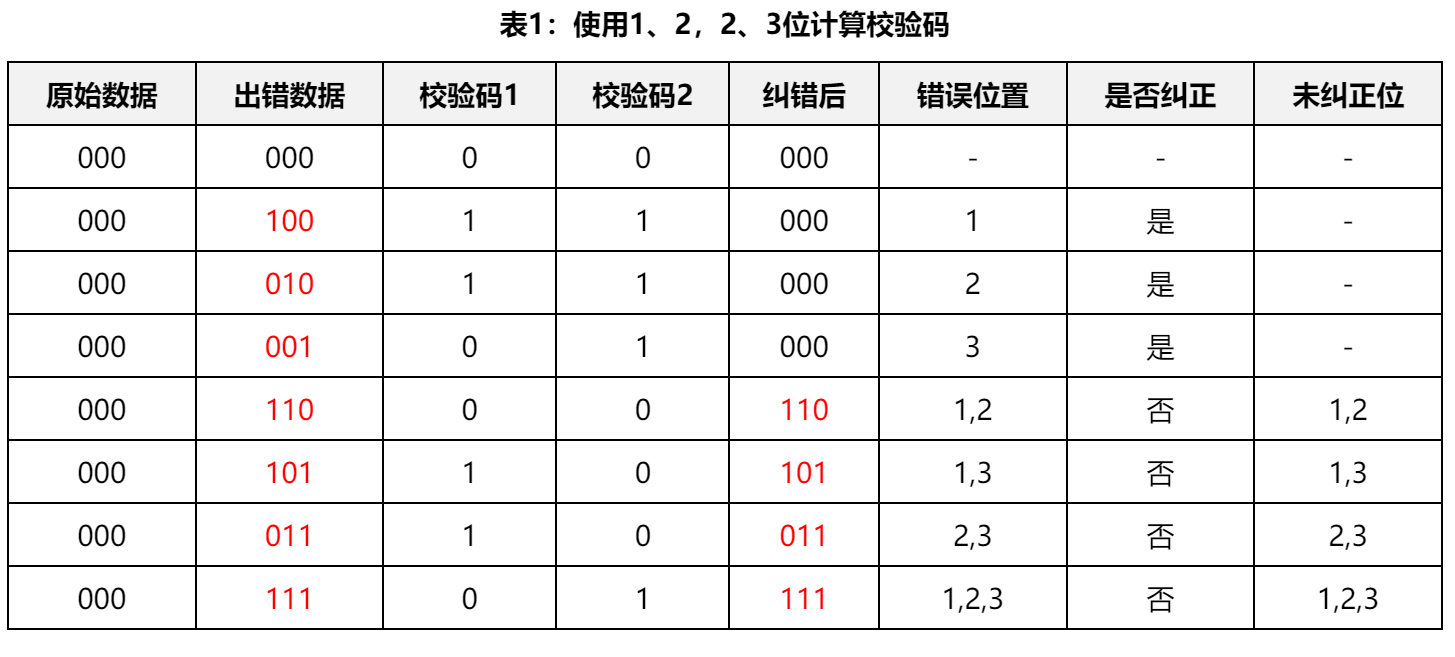


结论：错误率0.01及以上完全恢复

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import gc
import copy
import sys
import os
import traceback
import torch
import csv

model_names = ['Qwen2-0.5B-Instruct']
for model_name in model_names:

    model_path = '/root/autodl-tmp/models/' + model_name
    # 重定向输出到文件
    log_file = '/root/autodl-tmp/ECC/result/'+model_name+'.txt'
    csv_file = '/root/autodl-tmp/ECC/result/'+model_name+'.csv'
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)
    sys.stdout = open(log_file, 'w', encoding='utf-8')


    def int_to_binary(x):
        return format(x, '08b')
    
    def hamming_encode(data):
        p1 = data[:, 0] ^ data[:, 1] ^ data[:, 3] ^ data[:, 4] ^ data[:, 6]
        p2 = data[:, 0] ^ data[:, 2] ^ data[:, 3] ^ data[:, 5] ^ data[:, 6]
        p3 = data[:, 1] ^ data[:, 2] ^ data[:, 3] ^ data[:, 7]
        p4 = data[:, 4] ^ data[:, 5] ^ data[:, 6] ^ data[:, 7]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1], data[:, 2], data[:, 3], 
                            p4, data[:, 4], data[:, 5], data[:, 6], data[:, 7]], dim=1)

    def hamming_decode(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4] ^ encoded[:, 6] ^ encoded[:, 8] ^ encoded[:, 10]
        s2 = encoded[:, 1] ^ encoded[:, 2] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 9] ^ encoded[:, 10]
        s3 = encoded[:, 3] ^ encoded[:, 4] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 11]
        s4 = encoded[:, 7] ^ encoded[:, 8] ^ encoded[:, 9] ^ encoded[:, 10] ^ encoded[:, 11]
        syndrome = s1 + 2*s2 + 4*s3 + 8*s4
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 13)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4], corrected[:, 5], corrected[:, 6],
                            corrected[:, 8], corrected[:, 9], corrected[:, 10], corrected[:, 11]], dim=1)

    def hamming_encode_2bits(data):
        p1 = data[:, 0] ^ data[:, 1]
        p2 = data[:, 0]
        p3 = data[:, 1]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1]], dim=1)

    def hamming_decode_2bits(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4]
        s2 = encoded[:, 1] ^ encoded[:, 2]
        s3 = encoded[:, 3] ^ encoded[:, 4]
        syndrome = s1 + 2*s2 + 4*s3
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 6)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4]], dim=1)

    def bit_flip(x, err_rate, err_type):
        device = x.device
        mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, 128], dtype=torch.uint8, device=device)
        
        if err_type in range(8):  # 对应于8个比特位中的一个
            flip_mask = (torch.rand(x.shape, device=device) < err_rate).bool()
            flip_bit = mask[7 - err_type]
            flipped = torch.where(flip_mask, x ^ flip_bit, x)
            return flipped, flip_mask, flipped
        elif err_type == 8:  # 所有位都可能翻转
            flip_mask = (torch.rand(x.shape + (8,), device=device) < err_rate).bool()
            flipped = x.unsqueeze(-1) ^ mask
            flipped = torch.where(flip_mask, flipped, x.unsqueeze(-1)).sum(dim=-1).byte()
            return flipped, flip_mask.any(dim=-1), flipped
        elif err_type == 9:  # ECC汉明码校验恢复（全部8位）
            data_bits = torch.zeros((x.shape[0], 8), dtype=torch.uint8, device=device)
            for i in range(8):
                data_bits[:, i] = (x >> i) & 1
            encoded = hamming_encode(data_bits)
            flip_mask = (torch.rand(encoded.shape, device=device) < err_rate).bool()
            flipped_encoded = encoded ^ flip_mask
            decoded_bits = hamming_decode(flipped_encoded)
            decoded = (decoded_bits * torch.tensor([1,2,4,8,16,32,64,128], dtype=torch.uint8, device=device)).sum(dim=1)
            flipped = (flipped_encoded[:, [2,4,5,6,8,9,10,11]] * torch.tensor([1,2,4,8,16,32,64,128], dtype=torch.uint8, device=device)).sum(dim=1)
            return decoded, flip_mask.any(dim=1), flipped
        elif err_type == 10:  # ECC汉明码校验恢复（仅前两位）
            top_two_bits = (x >> 6) & 0b11
            p1 = top_two_bits ^ (top_two_bits >> 1)
            p2 = top_two_bits >> 1
            p3 = top_two_bits & 1
            encoded = (p1 << 2) | (p2 << 1) | p3
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * torch.randint(0, 8, x.shape, device=device))
            s1 = (flipped_encoded >> 2) ^ (flipped_encoded >> 1) ^ (flipped_encoded & 1)
            s2 = (flipped_encoded >> 2) ^ (flipped_encoded >> 1)
            s3 = (flipped_encoded >> 2) ^ (flipped_encoded & 1)
            syndrome = (s1 << 2) | (s2 << 1) | s3
            corrected = flipped_encoded ^ syndrome
            new_top_two_bits = ((corrected >> 1) & 2) | (corrected & 1)
            changed_mask = new_top_two_bits != top_two_bits
            result = (x & 0b00111111) | (new_top_two_bits << 6)
            flipped = (x & 0b00111111) | (((flipped_encoded >> 1) & 2) | (flipped_encoded & 1)) << 6
            return result, changed_mask, flipped
        elif err_type == 11:  # 新的ECC方案，使用两个校验位保护前三位
            top_three_bits = (x >> 5) & 0b111
            p1 = ((top_three_bits >> 2) & 1) ^ ((top_three_bits >> 1) & 1)  # b7 ^ b6
            p2 = ((top_three_bits >> 1) & 1) ^ (top_three_bits & 1)  # b6 ^ b5
            encoded = (p1 << 4) | (p2 << 3) | top_three_bits
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * (torch.randint(0, 8, x.shape, device=device) & 0b111))
            
            # 解码和错误检测（全部并行操作）
            b7 = (flipped_encoded >> 2) & 1
            b6 = (flipped_encoded >> 1) & 1
            b5 = flipped_encoded & 1
            p1_new = b7 ^ b6
            p2_new = b6 ^ b5
            p1_orig = (flipped_encoded >> 4) & 1
            p2_orig = (flipped_encoded >> 3) & 1
            
            # 错误模式检测（并行操作）
            error_pattern = (p1_new != p1_orig).to(torch.uint8) | ((p2_new != p2_orig).to(torch.uint8) << 1)
            
            # 错误纠正（并行操作）
            b7_corrected = b7 ^ ((error_pattern == 0b01).to(torch.uint8))
            b6_corrected = b6 ^ ((error_pattern == 0b11).to(torch.uint8))
            b5_corrected = b5 ^ ((error_pattern == 0b10).to(torch.uint8))
            
            corrected_top_bits = (b7_corrected << 2) | (b6_corrected << 1) | b5_corrected
            result = (x & 0b00011111) | (corrected_top_bits << 5)
            flipped = (x & 0b00011111) | ((flipped_encoded & 0b111) << 5)
            changed_mask = result != x
            return result, changed_mask, flipped
        else:
            raise ValueError("Invalid err_type. Must be 0-11.")

    def process_int8_params_batch(model, err_rate, err_type, batch_size=1000000, layers_to_process=None):
        with torch.no_grad():
            for name, param in model.named_parameters():
                if layers_to_process and not any(layer in name for layer in layers_to_process):
                    continue
                if param.dtype == torch.int8:
                    uint8_param = param.byte()
                    original_shape = uint8_param.shape
                    flattened = uint8_param.view(-1)
                    
                    batch = flattened[:batch_size]
                    corrected_batch, changed_mask, flipped_batch = bit_flip(batch, err_rate, err_type)
                    
                    changed_indices = torch.where(changed_mask)[0]
                    num_changed = changed_indices.size(0)

                    if num_changed > 0:
                        print(f"\nParameter: {name}")
                        print(f"Number of changed elements: {num_changed}")
                        print("First 10 changed elements (original -> flipped -> corrected):")
                        for i in range(min(10, num_changed)):
                            idx = changed_indices[i]
                            original = batch[idx].item()
                            flipped = flipped_batch[idx].item()
                            corrected = corrected_batch[idx].item()
                            print(f"{original:3d}: {int_to_binary(original)} -> {flipped:3d}: {int_to_binary(flipped)} -> {corrected:3d}: {int_to_binary(corrected)}")

                    num_flipped = changed_mask.sum().item()
                    total_bits = batch.numel() * (2 if err_type == 10 else (3 if err_type == 11 else 8))
                    actual_flip_rate = num_flipped / total_bits
                    print(f"\nNumber of flipped bits: {num_flipped}")
                    print(f"Total bits: {total_bits}")
                    print(f"Actual flip rate: {actual_flip_rate:.6f}")
                    print(f"Target flip rate: {err_rate:.6f}")
                    
                    flattened[:batch_size] = corrected_batch
                    
                    new_param = flattened.view(original_shape).to(torch.int8)
                    param.data.copy_(new_param)
                    print(f"Processed parameter: {name}")

    def get_model_info(model):
        params_list = []
        total_params = 0
        total_params_non_trainable = 0
        total_int8_params = 0

        for name, param in model.named_parameters():
            layer_name = name.split('.')[0]
            layer = dict(model.named_modules())[layer_name]
            layer_class = layer.__class__.__name__

            params_count = param.numel()
            trainable = param.requires_grad

            if param.dtype == torch.int8:
                params_list.append({
                    'tensor': name,
                    'layer_class': layer_class,
                    'shape': str(list(param.size())),
                    'precision': str(param.dtype).split('.')[-1],
                    'params_count': str(params_count),
                    'trainable': str(trainable),
                    'device': str(param.device)
                })
                total_int8_params += params_count

            total_params += params_count
            if not trainable:
                total_params_non_trainable += params_count

        total_params_trainable = total_params - total_params_non_trainable
        total_params_info = {
            'total_params': total_params,
            'total_params_trainable': total_params_trainable,
            'total_params_non_trainable': total_params_non_trainable,
            'total_int8_params': total_int8_params
        }

        return total_params_info, params_list

    def evaluate_model(model, tokenizer):
        prompt = "请用一句话总结人工智能的重要性。"
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            generated_ids = model.generate(
                model_inputs.input_ids,
                max_new_tokens=100
            )
        
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(f"Model response: {response}")
        return response

    def check_param_changes(model_before, model_after):
        changes = []
        total_params = 0
        changed_params = 0

        for (name1, param1), (name2, param2) in zip(model_before.named_parameters(), model_after.named_parameters()):
            if name1 != name2:
                raise ValueError(f"Parameter names do not match: {name1} vs {name2}")

            if param1.dtype == torch.int8:
                total_params += param1.numel()
                diff = (param1 != param2).sum().item()
                changed_params += diff
                if diff > 0:
                    changes.append({
                        'name': name1,
                        'total': param1.numel(),
                        'changed': diff,
                        'percentage': (diff / param1.numel()) * 100
                    })

        overall_change_percentage = (changed_params / total_params) * 100 if total_params > 0 else 0

        return changes, overall_change_percentage

    def run_experiment(err_rate, err_type):
        print(f"Running experiment with ERR_Rate: {err_rate}, ERR_Type: {err_type}")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_quant_type="nf8",
            bnb_8bit_compute_dtype=torch.bfloat16
        )

        tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

        model_before = copy.deepcopy(model)

        try:
            process_int8_params_batch(model, err_rate, err_type, batch_size=1000000)

            changes, overall_change_percentage = check_param_changes(model_before, model)

            print("Evaluating model performance:")
            response = evaluate_model(model, tokenizer)  # 使用注入错误后的模型进行评估

            print("Experiment completed.")
            return overall_change_percentage, response, changes
        except Exception as e:
            print(f"Error occurred during experiment:")
            print(f"ERR_Rate: {err_rate}, ERR_Type: {err_type}")
            print(traceback.format_exc())
            return None, None, None
        finally:
            del model
            del model_before
            torch.cuda.empty_cache()
            gc.collect()

    if __name__ == "__main__":
        err_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
        err_types = range(12)  # 0-11，包括新添加的类型11
        err_types = [11]
        results = []

        for i, err_rate in enumerate(err_rates):
            for j, err_type in enumerate(err_types):
                print('='*50)
                print(f"Starting experiment {i*len(err_types) + j + 1} of {len(err_rates)*len(err_types)}")
                overall_change_percentage, response, changes = run_experiment(err_rate, err_type)
                results.append({
                    'err_rate': err_rate,
                    'err_type': err_type,
                    'overall_change_percentage': overall_change_percentage,
                    'response': response,
                    'changes': changes
                })

        # 将结果写入CSV文件
        with open(csv_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['ERR_Rate', 'ERR_Type', 'Overall Change Percentage', 'Response'])
            for result in results:
                writer.writerow([
                    result['err_rate'],
                    result['err_type'],
                    result['overall_change_percentage'],
                    result['response']
                ])

        print("\n===== Overall Results =====")
        for result in results:
            print(f"ERR_Rate: {result['err_rate']}, ERR_Type: {result['err_type']}")
            print(f"Overall Change Percentage: {result['overall_change_percentage']:.4f}%")
            print(f"Model Response: {result['response']}")
            if result['changes']:
                print("Top 5 most changed parameters:")
                sorted_changes = sorted(result['changes'], key=lambda x: x['percentage'], reverse=True)
                for change in sorted_changes[:5]:
                    print(f"  {change['name']}: {change['percentage']:.2f}% ({change['changed']} / {change['total']})")
            print("-" * 30)

    sys.stdout.close()
    sys.stdout = sys.__stdout__

### 改进ECC纠正前两位（8，10）

1. 仍然只使用两个校验位，保持了存储效率。

2. 校验位的计算方式：
   - p1 = b7 ^ b6
   - p2 = b7 ^ b5
   这确保了b7参与了所有校验位的计算。

3. 错误纠正逻辑：
   - 当p1和p2都不匹配时，纠正b7
   - 当只有p1不匹配时，纠正b6
   - 当只有p2不匹配时，纠正b5

4. 额外的b7纠正逻辑：
   - 当只有一个校验位不匹配，且b7与b6和b5都不同时，我们认为b7更可能是错误的，因此纠正b7。
   这种情况下，我们牺牲了对b6或b5的单一错误纠正，来换取对b7更高的纠错概率。

这种设计的优点：

1. 只使用两个校验位，保持了存储效率。

2. 为b7提供了更高的纠错能力。在某些情况下，即使标准的纠错逻辑可能会错误地纠正b6或b5，我们的额外逻辑仍然可能正确地纠正b7。

3. 保持了对所有三个位的基本纠错能力。

缺点：

1. 在某些特定的错误模式下（例如，b7错误且b6或b5也错误），可能会错误地"纠正"b7。

2. b6和b5的纠错能力略有降低，因为在某些情况下，我们选择纠正b7而不是它们。

这种设计在保持两个校验位的情况下，尽可能地提高了对b7的保护。它适用于b7非常重要，且错误通常是单比特错误的场景。在实际应用中，您可能需要根据具体的错误统计和系统需求来评估这种方案的效果。

结论：错误率0.01及以上完全恢复

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import gc
import copy
import sys
import os
import traceback
import torch
import csv

model_names = ['Qwen2-0.5B-Instruct']
for model_name in model_names:

    model_path = '/root/autodl-tmp/models/' + model_name
    # 重定向输出到文件
    log_file = '/root/autodl-tmp/ECC/result/'+model_name+'.txt'
    csv_file = '/root/autodl-tmp/ECC/result/'+model_name+'.csv'
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)
    sys.stdout = open(log_file, 'w', encoding='utf-8')


    def int_to_binary(x):
        return format(x, '08b')
    
    def hamming_encode(data):
        p1 = data[:, 0] ^ data[:, 1] ^ data[:, 3] ^ data[:, 4] ^ data[:, 6]
        p2 = data[:, 0] ^ data[:, 2] ^ data[:, 3] ^ data[:, 5] ^ data[:, 6]
        p3 = data[:, 1] ^ data[:, 2] ^ data[:, 3] ^ data[:, 7]
        p4 = data[:, 4] ^ data[:, 5] ^ data[:, 6] ^ data[:, 7]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1], data[:, 2], data[:, 3], 
                            p4, data[:, 4], data[:, 5], data[:, 6], data[:, 7]], dim=1)

    def hamming_decode(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4] ^ encoded[:, 6] ^ encoded[:, 8] ^ encoded[:, 10]
        s2 = encoded[:, 1] ^ encoded[:, 2] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 9] ^ encoded[:, 10]
        s3 = encoded[:, 3] ^ encoded[:, 4] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 11]
        s4 = encoded[:, 7] ^ encoded[:, 8] ^ encoded[:, 9] ^ encoded[:, 10] ^ encoded[:, 11]
        syndrome = s1 + 2*s2 + 4*s3 + 8*s4
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 13)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4], corrected[:, 5], corrected[:, 6],
                            corrected[:, 8], corrected[:, 9], corrected[:, 10], corrected[:, 11]], dim=1)

    def hamming_encode_2bits(data):
        p1 = data[:, 0] ^ data[:, 1]
        p2 = data[:, 0]
        p3 = data[:, 1]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1]], dim=1)

    def hamming_decode_2bits(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4]
        s2 = encoded[:, 1] ^ encoded[:, 2]
        s3 = encoded[:, 3] ^ encoded[:, 4]
        syndrome = s1 + 2*s2 + 4*s3
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 6)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4]], dim=1)

    def bit_flip(x, err_rate, err_type):
        device = x.device
        mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, 128], dtype=torch.uint8, device=device)
        
        if err_type in range(8):  # 对应于8个比特位中的一个
            flip_mask = (torch.rand(x.shape, device=device) < err_rate).bool()
            flip_bit = mask[7 - err_type]
            flipped = torch.where(flip_mask, x ^ flip_bit, x)
            return flipped, flip_mask, flipped
        elif err_type == 8:  # 所有位都可能翻转
            flip_mask = (torch.rand(x.shape + (8,), device=device) < err_rate).bool()
            flipped = x.unsqueeze(-1) ^ mask
            flipped = torch.where(flip_mask, flipped, x.unsqueeze(-1)).sum(dim=-1).byte()
            return flipped, flip_mask.any(dim=-1), flipped
        elif err_type == 9:  # ECC汉明码校验恢复（全部8位）
            data_bits = torch.zeros((x.shape[0], 8), dtype=torch.uint8, device=device)
            for i in range(8):
                data_bits[:, i] = (x >> i) & 1
            encoded = hamming_encode(data_bits)
            flip_mask = (torch.rand(encoded.shape, device=device) < err_rate).bool()
            flipped_encoded = encoded ^ flip_mask
            decoded_bits = hamming_decode(flipped_encoded)
            decoded = (decoded_bits * torch.tensor([1,2,4,8,16,32,64,128], dtype=torch.uint8, device=device)).sum(dim=1)
            flipped = (flipped_encoded[:, [2,4,5,6,8,9,10,11]] * torch.tensor([1,2,4,8,16,32,64,128], dtype=torch.uint8, device=device)).sum(dim=1)
            return decoded, flip_mask.any(dim=1), flipped
        elif err_type == 10:  # ECC汉明码校验恢复（仅前两位）
            top_two_bits = (x >> 6) & 0b11
            p1 = top_two_bits ^ (top_two_bits >> 1)
            p2 = top_two_bits >> 1
            p3 = top_two_bits & 1
            encoded = (p1 << 2) | (p2 << 1) | p3
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * torch.randint(0, 8, x.shape, device=device))
            s1 = (flipped_encoded >> 2) ^ (flipped_encoded >> 1) ^ (flipped_encoded & 1)
            s2 = (flipped_encoded >> 2) ^ (flipped_encoded >> 1)
            s3 = (flipped_encoded >> 2) ^ (flipped_encoded & 1)
            syndrome = (s1 << 2) | (s2 << 1) | s3
            corrected = flipped_encoded ^ syndrome
            new_top_two_bits = ((corrected >> 1) & 2) | (corrected & 1)
            changed_mask = new_top_two_bits != top_two_bits
            result = (x & 0b00111111) | (new_top_two_bits << 6)
            flipped = (x & 0b00111111) | (((flipped_encoded >> 1) & 2) | (flipped_encoded & 1)) << 6
            return result, changed_mask, flipped
        elif err_type == 11:  # 新的ECC方案，使用两个校验位保护前三位
            top_three_bits = (x >> 5) & 0b111
            p1 = ((top_three_bits >> 2) & 1) ^ ((top_three_bits >> 1) & 1)  # b7 ^ b6
            p2 = ((top_three_bits >> 1) & 1) ^ (top_three_bits & 1)  # b6 ^ b5
            encoded = (p1 << 4) | (p2 << 3) | top_three_bits
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * (torch.randint(0, 8, x.shape, device=device) & 0b111))
            
            # 解码和错误检测（全部并行操作）
            b7 = (flipped_encoded >> 2) & 1
            b6 = (flipped_encoded >> 1) & 1
            b5 = flipped_encoded & 1
            p1_new = b7 ^ b6
            p2_new = b6 ^ b5
            p1_orig = (flipped_encoded >> 4) & 1
            p2_orig = (flipped_encoded >> 3) & 1
            
            # 错误模式检测（并行操作）
            error_pattern = (p1_new != p1_orig).to(torch.uint8) | ((p2_new != p2_orig).to(torch.uint8) << 1)
            
            # 错误纠正（并行操作）
            b7_corrected = b7 ^ ((error_pattern == 0b01).to(torch.uint8))
            b6_corrected = b6 ^ ((error_pattern == 0b11).to(torch.uint8))
            b5_corrected = b5 ^ ((error_pattern == 0b10).to(torch.uint8))
            
            corrected_top_bits = (b7_corrected << 2) | (b6_corrected << 1) | b5_corrected
            result = (x & 0b00011111) | (corrected_top_bits << 5)
            flipped = (x & 0b00011111) | ((flipped_encoded & 0b111) << 5)
            changed_mask = result != x
            return result, changed_mask, flipped
        elif err_type == 12:  # 新的ECC方案，使用两个校验位但侧重于保护第一位（b7）
            top_three_bits = (x >> 5) & 0b111
            p1 = ((top_three_bits >> 2) & 1) ^ ((top_three_bits >> 1) & 1)  # p1 = b7 ^ b6
            p2 = ((top_three_bits >> 2) & 1) ^ (top_three_bits & 1)  # p2 = b7 ^ b5
            encoded = (p1 << 4) | (p2 << 3) | top_three_bits
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * (torch.randint(0, 8, x.shape, device=device) & 0b111))
            
            # 解码和错误检测（全部并行操作）
            b7 = (flipped_encoded >> 2) & 1
            b6 = (flipped_encoded >> 1) & 1
            b5 = flipped_encoded & 1
            p1_new = b7 ^ b6
            p2_new = b7 ^ b5
            p1_orig = (flipped_encoded >> 4) & 1
            p2_orig = (flipped_encoded >> 3) & 1
            
            # 错误模式检测（并行操作）
            error_pattern = ((p1_new != p1_orig).to(torch.uint8) << 1) | (p2_new != p2_orig).to(torch.uint8)
            
            # 错误纠正（并行操作）
            b7_corrected = b7 ^ ((error_pattern == 0b11).to(torch.uint8))
            b6_corrected = b6 ^ ((error_pattern == 0b01).to(torch.uint8))
            b5_corrected = b5 ^ ((error_pattern == 0b10).to(torch.uint8))
            
            # 额外的b7纠正逻辑
            potential_b7_error = (error_pattern == 0b01) | (error_pattern == 0b10)
            b7_additional_check = (b7 != b6) & (b7 != b5) & potential_b7_error
            b7_corrected = b7_corrected ^ b7_additional_check
            
            corrected_top_bits = (b7_corrected << 2) | (b6_corrected << 1) | b5_corrected
            result = (x & 0b00011111) | (corrected_top_bits << 5)
            flipped = (x & 0b00011111) | ((flipped_encoded & 0b111) << 5)
            changed_mask = result != x
            return result, changed_mask, flipped
        else:
            raise ValueError("Invalid err_type. Must be 0-12.")

    def process_int8_params_batch(model, err_rate, err_type, batch_size=1000000, layers_to_process=None):
        with torch.no_grad():
            for name, param in model.named_parameters():
                if layers_to_process and not any(layer in name for layer in layers_to_process):
                    continue
                if param.dtype == torch.int8:
                    uint8_param = param.byte()
                    original_shape = uint8_param.shape
                    flattened = uint8_param.view(-1)
                    
                    batch = flattened[:batch_size]
                    corrected_batch, changed_mask, flipped_batch = bit_flip(batch, err_rate, err_type)
                    
                    changed_indices = torch.where(changed_mask)[0]
                    num_changed = changed_indices.size(0)

                    if num_changed > 0:
                        print(f"\nParameter: {name}")
                        print(f"Number of changed elements: {num_changed}")
                        print("First 10 changed elements (original -> flipped -> corrected):")
                        for i in range(min(10, num_changed)):
                            idx = changed_indices[i]
                            original = batch[idx].item()
                            flipped = flipped_batch[idx].item()
                            corrected = corrected_batch[idx].item()
                            print(f"{original:3d}: {int_to_binary(original)} -> {flipped:3d}: {int_to_binary(flipped)} -> {corrected:3d}: {int_to_binary(corrected)}")

                    num_flipped = changed_mask.sum().item()
                    total_bits = batch.numel() * (2 if err_type == 10 else (3 if err_type == 11 else 8))
                    actual_flip_rate = num_flipped / total_bits
                    print(f"\nNumber of flipped bits: {num_flipped}")
                    print(f"Total bits: {total_bits}")
                    print(f"Actual flip rate: {actual_flip_rate:.6f}")
                    print(f"Target flip rate: {err_rate:.6f}")
                    
                    flattened[:batch_size] = corrected_batch
                    
                    new_param = flattened.view(original_shape).to(torch.int8)
                    param.data.copy_(new_param)
                    print(f"Processed parameter: {name}")

    def get_model_info(model):
        params_list = []
        total_params = 0
        total_params_non_trainable = 0
        total_int8_params = 0

        for name, param in model.named_parameters():
            layer_name = name.split('.')[0]
            layer = dict(model.named_modules())[layer_name]
            layer_class = layer.__class__.__name__

            params_count = param.numel()
            trainable = param.requires_grad

            if param.dtype == torch.int8:
                params_list.append({
                    'tensor': name,
                    'layer_class': layer_class,
                    'shape': str(list(param.size())),
                    'precision': str(param.dtype).split('.')[-1],
                    'params_count': str(params_count),
                    'trainable': str(trainable),
                    'device': str(param.device)
                })
                total_int8_params += params_count

            total_params += params_count
            if not trainable:
                total_params_non_trainable += params_count

        total_params_trainable = total_params - total_params_non_trainable
        total_params_info = {
            'total_params': total_params,
            'total_params_trainable': total_params_trainable,
            'total_params_non_trainable': total_params_non_trainable,
            'total_int8_params': total_int8_params
        }

        return total_params_info, params_list

    def evaluate_model(model, tokenizer):
        prompt = "请用一句话总结人工智能的重要性。"
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            generated_ids = model.generate(
                model_inputs.input_ids,
                max_new_tokens=100
            )
        
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(f"Model response: {response}")
        return response

    def check_param_changes(model_before, model_after):
        changes = []
        total_params = 0
        changed_params = 0

        for (name1, param1), (name2, param2) in zip(model_before.named_parameters(), model_after.named_parameters()):
            if name1 != name2:
                raise ValueError(f"Parameter names do not match: {name1} vs {name2}")

            if param1.dtype == torch.int8:
                total_params += param1.numel()
                diff = (param1 != param2).sum().item()
                changed_params += diff
                if diff > 0:
                    changes.append({
                        'name': name1,
                        'total': param1.numel(),
                        'changed': diff,
                        'percentage': (diff / param1.numel()) * 100
                    })

        overall_change_percentage = (changed_params / total_params) * 100 if total_params > 0 else 0

        return changes, overall_change_percentage

    def run_experiment(err_rate, err_type):
        print(f"Running experiment with ERR_Rate: {err_rate}, ERR_Type: {err_type}")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_quant_type="nf8",
            bnb_8bit_compute_dtype=torch.bfloat16
        )

        tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

        model_before = copy.deepcopy(model)

        try:
            process_int8_params_batch(model, err_rate, err_type, batch_size=1000000)

            changes, overall_change_percentage = check_param_changes(model_before, model)

            print("Evaluating model performance:")
            response = evaluate_model(model, tokenizer)  # 使用注入错误后的模型进行评估

            print("Experiment completed.")
            return overall_change_percentage, response, changes
        except Exception as e:
            print(f"Error occurred during experiment:")
            print(f"ERR_Rate: {err_rate}, ERR_Type: {err_type}")
            print(traceback.format_exc())
            return None, None, None
        finally:
            del model
            del model_before
            torch.cuda.empty_cache()
            gc.collect()

    if __name__ == "__main__":
        err_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
        err_types = range(13)  # 0-12，包括新添加的类型12  # 0-11，包括新添加的类型11
        err_types = [12]
        results = []

        for i, err_rate in enumerate(err_rates):
            for j, err_type in enumerate(err_types):
                print('='*50)
                print(f"Starting experiment {i*len(err_types) + j + 1} of {len(err_rates)*len(err_types)}")
                overall_change_percentage, response, changes = run_experiment(err_rate, err_type)
                results.append({
                    'err_rate': err_rate,
                    'err_type': err_type,
                    'overall_change_percentage': overall_change_percentage,
                    'response': response,
                    'changes': changes
                })

        # 将结果写入CSV文件
        with open(csv_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['ERR_Rate', 'ERR_Type', 'Overall Change Percentage', 'Response'])
            for result in results:
                writer.writerow([
                    result['err_rate'],
                    result['err_type'],
                    result['overall_change_percentage'],
                    result['response']
                ])

        print("\n===== Overall Results =====")
        for result in results:
            print(f"ERR_Rate: {result['err_rate']}, ERR_Type: {result['err_type']}")
            print(f"Overall Change Percentage: {result['overall_change_percentage']:.4f}%")
            print(f"Model Response: {result['response']}")
            if result['changes']:
                print("Top 5 most changed parameters:")
                sorted_changes = sorted(result['changes'], key=lambda x: x['percentage'], reverse=True)
                for change in sorted_changes[:5]:
                    print(f"  {change['name']}: {change['percentage']:.2f}% ({change['changed']} / {change['total']})")
            print("-" * 30)

    sys.stdout.close()
    sys.stdout = sys.__stdout__

### 有符号ECC


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import gc
import copy
import sys
import os
import traceback
import torch
import csv

model_names = ['Qwen2-0.5B-Instruct']
for model_name in model_names:

    model_path = '/root/autodl-tmp/models/' + model_name
    # 重定向输出到文件
    log_file = '/root/autodl-tmp/ECC/result/'+model_name+'.txt'
    csv_file = '/root/autodl-tmp/ECC/result/'+model_name+'.csv'
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)
    sys.stdout = open(log_file, 'w', encoding='utf-8')

    def int_to_binary(x):
        return format(x & 0xFF, '08b')  # 使用位与操作确保我们只处理最后8位
    
    def hamming_encode(data):
        p1 = data[:, 0] ^ data[:, 1] ^ data[:, 3] ^ data[:, 4] ^ data[:, 6]
        p2 = data[:, 0] ^ data[:, 2] ^ data[:, 3] ^ data[:, 5] ^ data[:, 6]
        p3 = data[:, 1] ^ data[:, 2] ^ data[:, 3] ^ data[:, 7]
        p4 = data[:, 4] ^ data[:, 5] ^ data[:, 6] ^ data[:, 7]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1], data[:, 2], data[:, 3], 
                            p4, data[:, 4], data[:, 5], data[:, 6], data[:, 7]], dim=1)

    def hamming_decode(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4] ^ encoded[:, 6] ^ encoded[:, 8] ^ encoded[:, 10]
        s2 = encoded[:, 1] ^ encoded[:, 2] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 9] ^ encoded[:, 10]
        s3 = encoded[:, 3] ^ encoded[:, 4] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 11]
        s4 = encoded[:, 7] ^ encoded[:, 8] ^ encoded[:, 9] ^ encoded[:, 10] ^ encoded[:, 11]
        syndrome = s1 + 2*s2 + 4*s3 + 8*s4
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 13)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4], corrected[:, 5], corrected[:, 6],
                            corrected[:, 8], corrected[:, 9], corrected[:, 10], corrected[:, 11]], dim=1)

    def hamming_encode_2bits(data):
        p1 = data[:, 0] ^ data[:, 1]
        p2 = data[:, 0]
        p3 = data[:, 1]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1]], dim=1)

    def hamming_decode_2bits(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4]
        s2 = encoded[:, 1] ^ encoded[:, 2]
        s3 = encoded[:, 3] ^ encoded[:, 4]
        syndrome = s1 + 2*s2 + 4*s3
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 6)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4]], dim=1)

    def bit_flip(x, err_rate, err_type):
        device = x.device
        mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, -128], dtype=torch.int8, device=device)
        
        if err_type in range(8):  # 对应于8个比特位中的一个
            flip_mask = (torch.rand(x.shape, device=device) < err_rate).bool()
            flip_bit = mask[7 - err_type]
            flipped = torch.where(flip_mask, x ^ flip_bit, x)
            return flipped, flip_mask, flipped
        elif err_type == 8:  # 所有位都可能翻转
            flip_mask = (torch.rand(x.shape + (8,), device=device) < err_rate).bool()
            flipped = x.unsqueeze(-1) ^ mask
            flipped = torch.where(flip_mask, flipped, x.unsqueeze(-1)).sum(dim=-1).to(torch.int8)
            return flipped, flip_mask.any(dim=-1), flipped
        elif err_type == 9:  # ECC汉明码校验恢复（全部8位）
            data_bits = torch.zeros((x.shape[0], 8), dtype=torch.int8, device=device)
            for i in range(8):
                data_bits[:, i] = (x >> i) & 1
            encoded = hamming_encode(data_bits)
            flip_mask = (torch.rand(encoded.shape, device=device) < err_rate).bool()
            flipped_encoded = encoded ^ flip_mask
            decoded_bits = hamming_decode(flipped_encoded)
            decoded = (decoded_bits * torch.tensor([1,2,4,8,16,32,64,-128], dtype=torch.int8, device=device)).sum(dim=1)
            flipped = (flipped_encoded[:, [2,4,5,6,8,9,10,11]] * torch.tensor([1,2,4,8,16,32,64,-128], dtype=torch.int8, device=device)).sum(dim=1)
            return decoded, flip_mask.any(dim=1), flipped
        elif err_type == 10:  # ECC汉明码校验恢复（仅前两位）
            top_two_bits = (x >> 6).to(torch.int8) & 0b11
            data_bits = torch.zeros((x.shape[0], 2), dtype=torch.int8, device=device)
            data_bits[:, 0] = (top_two_bits >> 1) & 1
            data_bits[:, 1] = top_two_bits & 1
            encoded = hamming_encode_2bits(data_bits)
            flip_mask = (torch.rand(encoded.shape, device=device) < err_rate).bool()
            flipped_encoded = encoded ^ flip_mask
            decoded_bits = hamming_decode_2bits(flipped_encoded)
            new_top_two_bits = (decoded_bits[:, 0] << 1) | decoded_bits[:, 1]
            result = (x & 0b00111111) | (new_top_two_bits << 6)
            flipped = (x & 0b00111111) | ((flipped_encoded[:, 2] << 7) | (flipped_encoded[:, 4] << 6))
            changed_mask = result != x
            return result, changed_mask, flipped
        elif err_type == 11:  # 新的ECC方案，使用两个校验位保护前三位
            top_three_bits = (x >> 5).to(torch.int8) & 0b111
            p1 = ((top_three_bits >> 2) & 1) ^ ((top_three_bits >> 1) & 1)  # b7 ^ b6
            p2 = ((top_three_bits >> 1) & 1) ^ (top_three_bits & 1)  # b6 ^ b5
            encoded = (p1 << 4) | (p2 << 3) | top_three_bits
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * (torch.randint(0, 8, x.shape, device=device) & 0b111))
            
            # 解码和错误检测（全部并行操作）
            b7 = (flipped_encoded >> 2) & 1
            b6 = (flipped_encoded >> 1) & 1
            b5 = flipped_encoded & 1
            p1_new = b7 ^ b6
            p2_new = b6 ^ b5
            p1_orig = (flipped_encoded >> 4) & 1
            p2_orig = (flipped_encoded >> 3) & 1
            
            # 错误模式检测（并行操作）
            error_pattern = (p1_new != p1_orig).to(torch.int8) | ((p2_new != p2_orig).to(torch.int8) << 1)
            
            # 错误纠正（并行操作）
            b7_corrected = b7 ^ ((error_pattern == 0b01).to(torch.int8))
            b6_corrected = b6 ^ ((error_pattern == 0b11).to(torch.int8))
            b5_corrected = b5 ^ ((error_pattern == 0b10).to(torch.int8))
            
            corrected_top_bits = (b7_corrected << 2) | (b6_corrected << 1) | b5_corrected
            result = (x & 0b00011111) | (corrected_top_bits << 5)
            flipped = (x & 0b00011111) | ((flipped_encoded & 0b111) << 5)
            changed_mask = result != x
            return result, changed_mask, flipped
        elif err_type == 12:  # 新的ECC方案，使用两个校验位但侧重于保护第一位（b7）
            top_three_bits = (x >> 5).to(torch.int8) & 0b111
            p1 = ((top_three_bits >> 2) & 1) ^ ((top_three_bits >> 1) & 1)  # p1 = b7 ^ b6
            p2 = ((top_three_bits >> 2) & 1) ^ (top_three_bits & 1)  # p2 = b7 ^ b5
            encoded = (p1 << 4) | (p2 << 3) | top_three_bits
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * (torch.randint(0, 8, x.shape, device=device) & 0b111))
            
            # 解码和错误检测（全部并行操作）
            b7 = (flipped_encoded >> 2) & 1
            b6 = (flipped_encoded >> 1) & 1
            b5 = flipped_encoded & 1
            p1_new = b7 ^ b6
            p2_new = b7 ^ b5
            p1_orig = (flipped_encoded >> 4) & 1
            p2_orig = (flipped_encoded >> 3) & 1
            
            # 错误模式检测（并行操作）
            error_pattern = ((p1_new != p1_orig).to(torch.int8) << 1) | (p2_new != p2_orig).to(torch.int8)
            
            # 错误纠正（并行操作）
            b7_corrected = b7 ^ ((error_pattern == 0b11).to(torch.int8))
            b6_corrected = b6 ^ ((error_pattern == 0b01).to(torch.int8))
            b5_corrected = b5 ^ ((error_pattern == 0b10).to(torch.int8))
            
            # 额外的b7纠正逻辑
            potential_b7_error = (error_pattern == 0b01) | (error_pattern == 0b10)
            b7_additional_check = (b7 != b6) & (b7 != b5) & potential_b7_error
            b7_corrected = b7_corrected ^ b7_additional_check
            
            corrected_top_bits = (b7_corrected << 2) | (b6_corrected << 1) | b5_corrected
            result = (x & 0b00011111) | (corrected_top_bits << 5)
            flipped = (x & 0b00011111) | ((flipped_encoded & 0b111) << 5)
            changed_mask = result != x
            return result, changed_mask, flipped
        else:
            raise ValueError("Invalid err_type. Must be 0-12.")

    def process_int8_params_batch(model, err_rate, err_type, batch_size=1000000, layers_to_process=None):
        with torch.no_grad():
            for name, param in model.named_parameters():
                if layers_to_process and not any(layer in name for layer in layers_to_process):
                    continue
                if param.dtype == torch.int8:
                    original_shape = param.shape
                    flattened = param.view(-1)
                    
                    batch = flattened[:batch_size]
                    corrected_batch, changed_mask, flipped_batch = bit_flip(batch, err_rate, err_type)
                    
                    changed_indices = torch.where(changed_mask)[0]
                    num_changed = changed_indices.size(0)

                    if num_changed > 0:
                        print(f"\nParameter: {name}")
                        print(f"Number of changed elements: {num_changed}")
                        print("First 10 changed elements (original -> flipped -> corrected):")
                        for i in range(min(10, num_changed)):
                            idx = changed_indices[i]
                            original = batch[idx].item()
                            flipped = flipped_batch[idx].item()
                            corrected = corrected_batch[idx].item()
                            print(f"{original:3d}: {int_to_binary(original)} -> {flipped:3d}: {int_to_binary(flipped)} -> {corrected:3d}: {int_to_binary(corrected)}")

                    num_flipped = changed_mask.sum().item()
                    total_bits = batch.numel() * (2 if err_type == 10 else (3 if err_type == 11 else 8))
                    actual_flip_rate = num_flipped / total_bits
                    print(f"\nNumber of flipped bits: {num_flipped}")
                    print(f"Total bits: {total_bits}")
                    print(f"Actual flip rate: {actual_flip_rate:.6f}")
                    print(f"Target flip rate: {err_rate:.6f}")
                    
                    flattened[:batch_size] = corrected_batch
                    
                    new_param = flattened.view(original_shape).to(torch.int8)
                    param.data.copy_(new_param)
                    print(f"Processed parameter: {name}")

    def get_model_info(model):
        params_list = []
        total_params = 0
        total_params_non_trainable = 0
        total_int8_params = 0

        for name, param in model.named_parameters():
            layer_name = name.split('.')[0]
            layer = dict(model.named_modules())[layer_name]
            layer_class = layer.__class__.__name__

            params_count = param.numel()
            trainable = param.requires_grad

            if param.dtype == torch.int8:
                params_list.append({
                    'tensor': name,
                    'layer_class': layer_class,
                    'shape': str(list(param.size())),
                    'precision': str(param.dtype).split('.')[-1],
                    'params_count': str(params_count),
                    'trainable': str(trainable),
                    'device': str(param.device)
                })
                total_int8_params += params_count

            total_params += params_count
            if not trainable:
                total_params_non_trainable += params_count

        total_params_trainable = total_params - total_params_non_trainable
        total_params_info = {
            'total_params': total_params,
            'total_params_trainable': total_params_trainable,
            'total_params_non_trainable': total_params_non_trainable,
            'total_int8_params': total_int8_params
        }

        return total_params_info, params_list

    def evaluate_model(model, tokenizer):
        prompt = "请用一句话总结人工智能的重要性。"
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            generated_ids = model.generate(
                model_inputs.input_ids,
                max_new_tokens=100
            )
        
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(f"Model response: {response}")
        return response

    def check_param_changes(model_before, model_after):
        changes = []
        total_params = 0
        changed_params = 0

        for (name1, param1), (name2, param2) in zip(model_before.named_parameters(), model_after.named_parameters()):
            if name1 != name2:
                raise ValueError(f"Parameter names do not match: {name1} vs {name2}")

            if param1.dtype == torch.int8:
                total_params += param1.numel()
                diff = (param1 != param2).sum().item()
                changed_params += diff
                if diff > 0:
                    changes.append({
                        'name': name1,
                        'total': param1.numel(),
                        'changed': diff,
                        'percentage': (diff / param1.numel()) * 100
                    })

        overall_change_percentage = (changed_params / total_params) * 100 if total_params > 0 else 0

        return changes, overall_change_percentage

    def run_experiment(err_rate, err_type):
        print(f"Running experiment with ERR_Rate: {err_rate}, ERR_Type: {err_type}")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_quant_type="nf8",
            bnb_8bit_compute_dtype=torch.bfloat16
        )

        tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

        model_before = copy.deepcopy(model)

        try:
            process_int8_params_batch(model, err_rate, err_type, batch_size=1000000)

            changes, overall_change_percentage = check_param_changes(model_before, model)

            print("Evaluating model performance:")
            response = evaluate_model(model, tokenizer)  # 使用注入错误后的模型进行评估

            print("Experiment completed.")
            return overall_change_percentage, response, changes
        except Exception as e:
            print(f"Error occurred during experiment:")
            print(f"ERR_Rate: {err_rate}, ERR_Type: {err_type}")
            print(traceback.format_exc())
            return None, None, None
        finally:
            del model
            del model_before
            torch.cuda.empty_cache()
            gc.collect()

    if __name__ == "__main__":
        err_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
        err_types = [11]
        results = []

        for i, err_rate in enumerate(err_rates):
            for j, err_type in enumerate(err_types):
                print('='*50)
                print(f"Starting experiment {i*len(err_types) + j + 1} of {len(err_rates)*len(err_types)}")
                overall_change_percentage, response, changes = run_experiment(err_rate, err_type)
                results.append({
                    'err_rate': err_rate,
                    'err_type': err_type,
                    'overall_change_percentage': overall_change_percentage,
                    'response': response,
                    'changes': changes
                })

        # 将结果写入CSV文件
        with open(csv_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['ERR_Rate', 'ERR_Type', 'Overall Change Percentage', 'Response'])
            for result in results:
                writer.writerow([
                    result['err_rate'],
                    result['err_type'],
                    result['overall_change_percentage'],
                    result['response']
                ])

        print("\n===== Overall Results =====")
        for result in results:
            print(f"ERR_Rate: {result['err_rate']}, ERR_Type: {result['err_type']}")
            print(f"Overall Change Percentage: {result['overall_change_percentage']:.4f}%")
            print(f"Model Response: {result['response']}")
            if result['changes']:
                print("Top 5 most changed parameters:")
                sorted_changes = sorted(result['changes'], key=lambda x: x['percentage'], reverse=True)
                for change in sorted_changes[:5]:
                    print(f"  {change['name']}: {change['percentage']:.2f}% ({change['changed']} / {change['total']})")
            print("-" * 30)

    sys.stdout.close()
    sys.stdout = sys.__stdout__

### ECC（8，10.025）
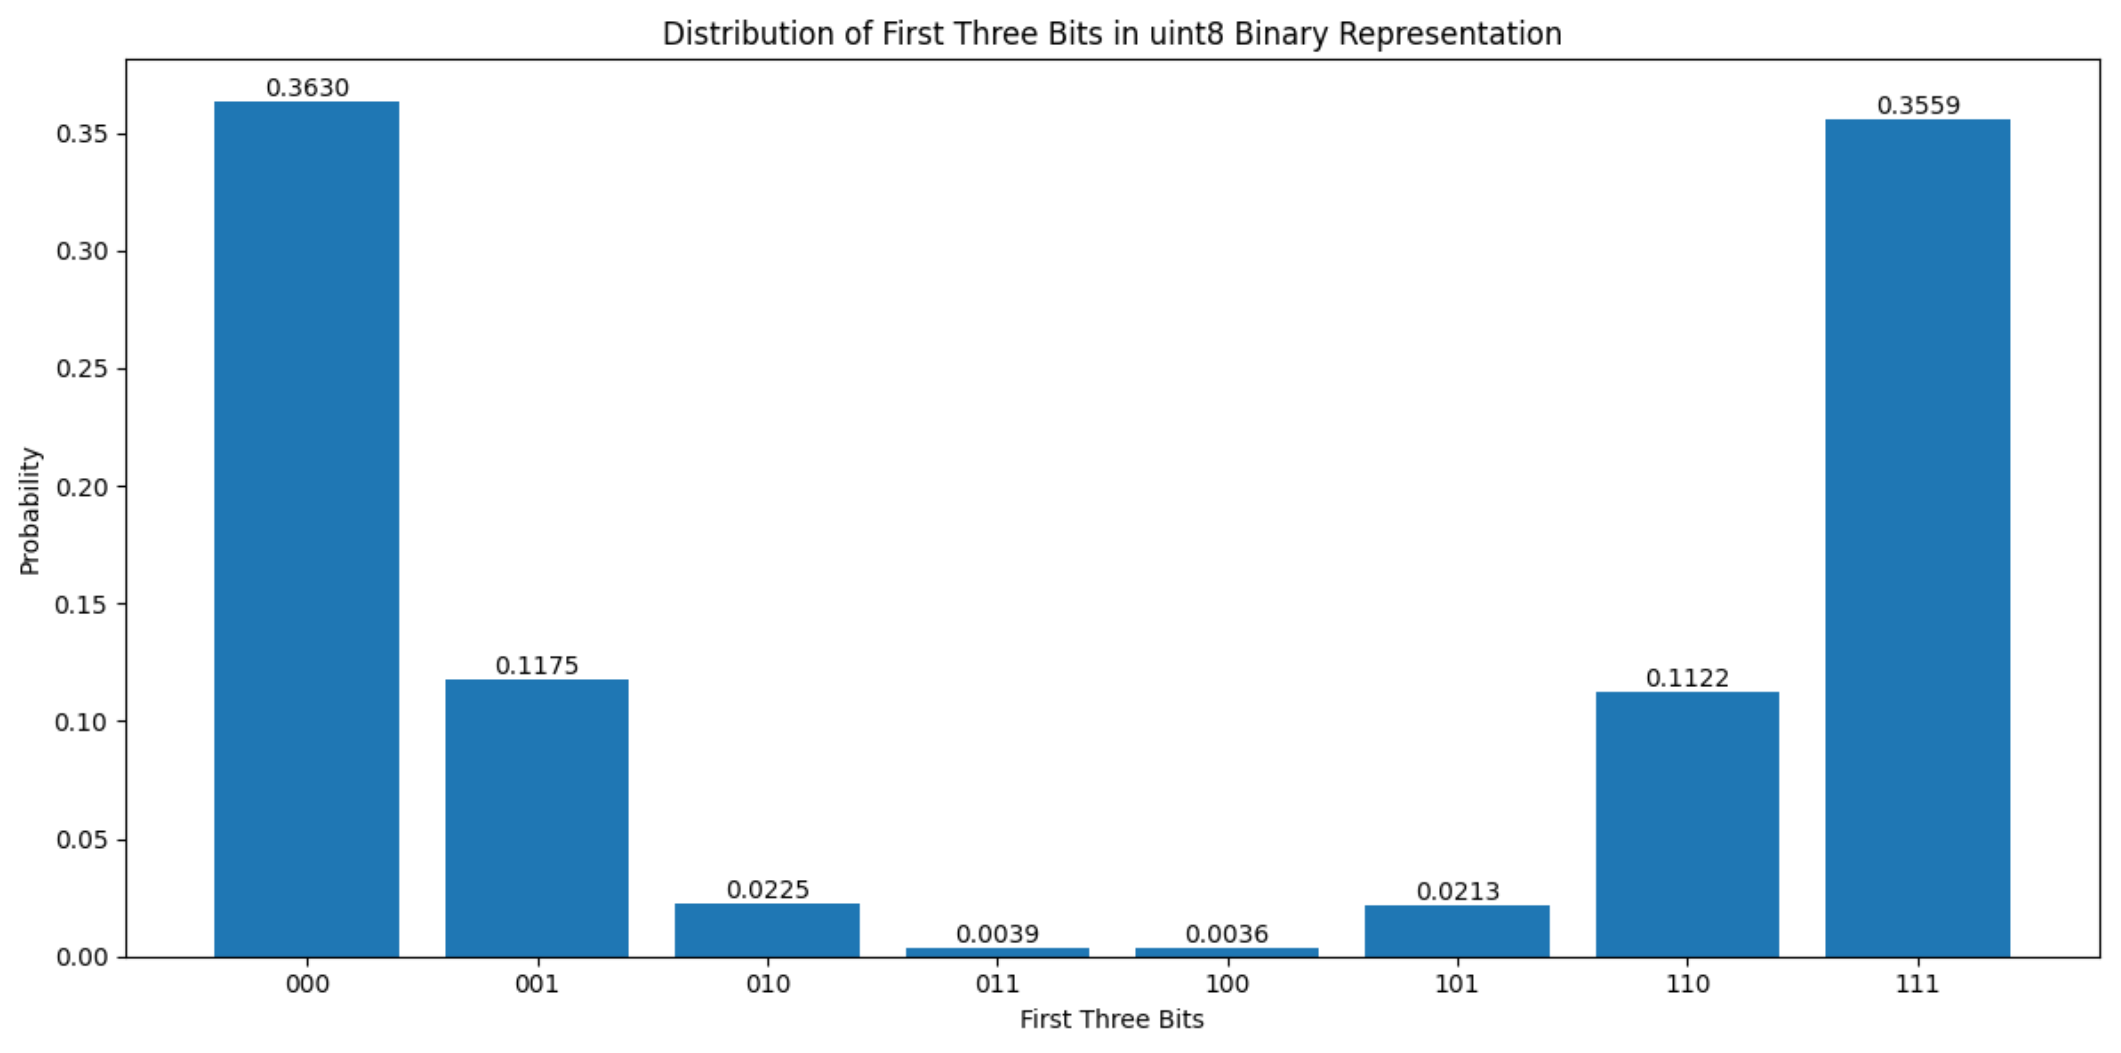
| 行号 | 数据位 | 原始 校验位1 | 原始 校验位2 | 可能的原始数据位 | 错误模式 | 是否会被判定为出错 |
|------|--------|--------------|--------------|------------------|----------|-------------------|
| 1    | 000    | 0            | 0            | 000, 111         | 000, 111 | 否                |
| 2    | 000    | 0            | 1            | 001, 110         | 001, 110 | 是                |
| 3    | 000    | 1            | 0            | 010, 101         | 010, 101 | 是                |
| 4    | 000    | 1            | 1            | 011, 100         | 011, 100 | 是                |
| 5    | 001    | 0            | 0            | 000, 111         | 001, 110 | 是                |
| 6    | 001    | 0            | 1            | 001, 110         | 000, 111 | 否                |
| 7    | 001    | 1            | 0            | 010, 101         | 011, 100 | 是                |
| 8    | 001    | 1            | 1            | 011, 100         | 010, 101 | 是                |
| 9    | 010    | 0            | 0            | 000, 111         | 010, 101 | 是                |
| 10   | 010    | 0            | 1            | 001, 110         | 011, 100 | 是                |
| 11   | 010    | 1            | 0            | 010, 101         | 000, 111 | 否                |
| 12   | 010    | 1            | 1            | 011, 100         | 001, 110 | 是                |
| 13   | 011    | 0            | 0            | 000, 111         | 011, 100 | 是                |
| 14   | 011    | 0            | 1            | 001, 110         | 010, 101 | 是                |
| 15   | 011    | 1            | 0            | 010, 101         | 001, 110 | 是                |
| 16   | 011    | 1            | 1            | 011, 100         | 000, 111 | 否                |
| 17   | 100    | 0            | 0            | 000, 111         | 011, 100 | 是                |
| 18   | 100    | 0            | 1            | 001, 110         | 010, 101 | 是                |
| 19   | 100    | 1            | 0            | 010, 101         | 001, 110 | 是                |
| 20   | 100    | 1            | 1            | 011, 100         | 000, 111 | 否                |
| 21   | 101    | 0            | 0            | 000, 111         | 010, 101 | 是                |
| 22   | 101    | 0            | 1            | 001, 110         | 011, 100 | 是                |
| 23   | 101    | 1            | 0            | 010, 101         | 000, 111 | 否                |
| 24   | 101    | 1            | 1            | 011, 100         | 001, 110 | 是                |
| 25   | 110    | 0            | 0            | 000, 111         | 001, 110 | 是                |
| 26   | 110    | 0            | 1            | 001, 110         | 000, 111 | 否                |
| 27   | 110    | 1            | 0            | 010, 101         | 011, 100 | 是                |
| 28   | 110    | 1            | 1            | 011, 100         | 010, 101 | 是                |
| 29   | 111    | 0            | 0            | 000, 111         | 000, 111 | 否                |
| 30   | 111    | 0            | 1            | 001, 110         | 001, 110 | 是                |
| 31   | 111    | 1            | 0            | 010, 101         | 010, 101 | 是                |
| 32   | 111    | 1            | 1            | 011, 100         | 011, 100 | 是                |

以及

| 行号 | 数据位 | 原始 校验位1 | 原始 校验位2 | 可能的原始数据位 | 错误模式 | 是否会被判定为出错 | 最有可能的原始数据位 | ECC纠正后的数据位 |
|------|--------|--------------|--------------|------------------|----------|-------------------|----------------------|-------------------|
| 1    | 000    | 0            | 0            | 000, 111         | 000, 111 | 否                |                      |                   |
| 2    | 000    | 0            | 1            | 001, 110         | 001, 110 | 是                | 001                  | 001               |
| 3    | 000    | 1            | 0            | 010, 101         | 010, 101 | 是                | 010                  | 010               |
| 4    | 000    | 1            | 1            | 011, 100         | 011, 100 | 是                | 011                  | 100               |
| 5    | 001    | 0            | 0            | 000, 111         | 001, 110 | 是                | 000                  | 000               |
| 6    | 001    | 0            | 1            | 001, 110         | 000, 111 | 否                |                      |                   |
| 7    | 001    | 1            | 0            | 010, 101         | 011, 100 | 是                | 010                  | 101               |
| 8    | 001    | 1            | 1            | 011, 100         | 010, 101 | 是                | 011                  | 011               |
| 9    | 010    | 0            | 0            | 000, 111         | 010, 101 | 是                | 000                  | 000               |
| 10   | 010    | 0            | 1            | 001, 110         | 011, 100 | 是                | 001                  | 110               |
| 11   | 010    | 1            | 0            | 010, 101         | 000, 111 | 否                |                      |                   |
| 12   | 010    | 1            | 1            | 011, 100         | 001, 110 | 是                | 011                  | 011               |
| 13   | 011    | 0            | 0            | 000, 111         | 011, 100 | 是                | 000                  | 111               |
| 14   | 011    | 0            | 1            | 001, 110         | 010, 101 | 是                | 001                  | 001               |
| 15   | 011    | 1            | 0            | 010, 101         | 001, 110 | 是                | 010                  | 010               |
| 16   | 011    | 1            | 1            | 011, 100         | 000, 111 | 否                |                      |                   |
| 17   | 100    | 0            | 0            | 000, 111         | 011, 100 | 是                | 000                  | 000               |
| 18   | 100    | 0            | 1            | 001, 110         | 010, 101 | 是                | 001                  | 110               |
| 19   | 100    | 1            | 0            | 010, 101         | 001, 110 | 是                | 010                  | 101               |
| 20   | 100    | 1            | 1            | 011, 100         | 000, 111 | 否                |                      |                   |
| 21   | 101    | 0            | 0            | 000, 111         | 010, 101 | 是                | 000                  | 111               |
| 22   | 101    | 0            | 1            | 001, 110         | 011, 100 | 是                | 001                  | 001               |
| 23   | 101    | 1            | 0            | 010, 101         | 000, 111 | 否                |                      |                   |
| 24   | 101    | 1            | 1            | 011, 100         | 001, 110 | 是                | 011                  | 100               |
| 25   | 110    | 0            | 0            | 000, 111         | 001, 110 | 是                | 000                  | 111               |
| 26   | 110    | 0            | 1            | 001, 110         | 000, 111 | 否                |                      |                   |
| 27   | 110    | 1            | 0            | 010, 101         | 011, 100 | 是                | 010                  | 010               |
| 28   | 110    | 1            | 1            | 011, 100         | 010, 101 | 是                | 011                  | 100               |
| 29   | 111    | 0            | 0            | 000, 111         | 000, 111 | 否                |                      |                   |
| 30   | 111    | 0            | 1            | 001, 110         | 001, 110 | 是                | 001                  | 110               |
| 31   | 111    | 1            | 0            | 010, 101         | 010, 101 | 是                | 010                  | 101               |
| 32   | 111    | 1            | 1            | 011, 100         | 011, 100 | 是                | 011                  | 011               |



但是此时由于对称性，导致了有两种还原可能的bit位无法择优还原，因为概率十分接近，那么是否可以通过对参数存储时对参数整体进行偏移，使得这个分布不对称来辅助ECC校验，最终统一在纠错后反偏移还原？


将参数数值全部+64之后记录溢出位

溢出位只有1/40的需求因此实际是（8，10.025）校验





In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import gc
import copy
import sys
import os
import traceback
import torch
import csv

model_names = ['Qwen2-0.5B-Instruct']
for model_name in model_names:

    model_path = '/root/autodl-tmp/models/' + model_name
    # 重定向输出到文件
    log_file = '/root/autodl-tmp/ECC/result/'+model_name+'.txt'
    csv_file = '/root/autodl-tmp/ECC/result/'+model_name+'.csv'
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)
    sys.stdout = open(log_file, 'w', encoding='utf-8')

    def int8_to_signed_binary(x):
        return ''.join(['1' if x & (1 << (7-i)) else '0' for i in range(8)])

    def hamming_encode(data):
        p1 = data[:, 0] ^ data[:, 1] ^ data[:, 3] ^ data[:, 4] ^ data[:, 6]
        p2 = data[:, 0] ^ data[:, 2] ^ data[:, 3] ^ data[:, 5] ^ data[:, 6]
        p3 = data[:, 1] ^ data[:, 2] ^ data[:, 3] ^ data[:, 7]
        p4 = data[:, 4] ^ data[:, 5] ^ data[:, 6] ^ data[:, 7]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1], data[:, 2], data[:, 3], 
                            p4, data[:, 4], data[:, 5], data[:, 6], data[:, 7]], dim=1)

    def hamming_decode(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4] ^ encoded[:, 6] ^ encoded[:, 8] ^ encoded[:, 10]
        s2 = encoded[:, 1] ^ encoded[:, 2] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 9] ^ encoded[:, 10]
        s3 = encoded[:, 3] ^ encoded[:, 4] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 11]
        s4 = encoded[:, 7] ^ encoded[:, 8] ^ encoded[:, 9] ^ encoded[:, 10] ^ encoded[:, 11]
        syndrome = s1 + 2*s2 + 4*s3 + 8*s4
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 13)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4], corrected[:, 5], corrected[:, 6],
                            corrected[:, 8], corrected[:, 9], corrected[:, 10], corrected[:, 11]], dim=1)

    def hamming_encode_2bits(data):
        p1 = data[:, 0] ^ data[:, 1]
        p2 = data[:, 0]
        p3 = data[:, 1]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1]], dim=1)

    def hamming_decode_2bits(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4]
        s2 = encoded[:, 1] ^ encoded[:, 2]
        s3 = encoded[:, 3] ^ encoded[:, 4]
        syndrome = s1 + 2*s2 + 4*s3
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 6)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4]], dim=1)

    def bit_flip(x, err_rate, err_type):
        device = x.device
        mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, -128], dtype=torch.int8, device=device)
        
        if err_type in range(8):  # 对应于8个比特位中的一个
            flip_mask = (torch.rand(x.shape, device=device) < err_rate).bool()
            flip_bit = mask[7 - err_type]
            flipped = torch.where(flip_mask, x ^ flip_bit, x).to(torch.int8)
            return flipped, flip_mask, flipped
        elif err_type == 8:  # 所有位都可能翻转
            flip_mask = (torch.rand(x.shape + (8,), device=device) < err_rate).bool()
            flipped = x.unsqueeze(-1) ^ mask
            flipped = torch.where(flip_mask, flipped, x.unsqueeze(-1)).sum(dim=-1).to(torch.int8)
            return flipped, flip_mask.any(dim=-1), flipped
        elif err_type == 9:  # ECC汉明码校验恢复（全部8位）
            data_bits = torch.zeros((x.shape[0], 8), dtype=torch.int8, device=device)
            for i in range(8):
                data_bits[:, i] = (x >> i) & 1
            encoded = hamming_encode(data_bits)
            flip_mask = (torch.rand(encoded.shape, device=device) < err_rate).bool()
            flipped_encoded = encoded ^ flip_mask
            decoded_bits = hamming_decode(flipped_encoded)
            decoded = (decoded_bits * torch.tensor([1,2,4,8,16,32,64,-128], dtype=torch.int8, device=device)).sum(dim=1).to(torch.int8)
            flipped = (flipped_encoded[:, [2,4,5,6,8,9,10,11]] * torch.tensor([1,2,4,8,16,32,64,-128], dtype=torch.int8, device=device)).sum(dim=1).to(torch.int8)
            return decoded, flip_mask.any(dim=1), flipped
        elif err_type == 11:  # 新的ECC方案，使用两个校验位保护前三位
            top_three_bits = (x >> 5).to(torch.int8) & 0b111
            p1 = ((top_three_bits >> 2) & 1) ^ ((top_three_bits >> 1) & 1)  # b7 ^ b6
            p2 = ((top_three_bits >> 1) & 1) ^ (top_three_bits & 1)  # b6 ^ b5
            encoded = (p1 << 4) | (p2 << 3) | top_three_bits
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * (torch.randint(0, 8, x.shape, device=device) & 0b111))
            
            # 解码和错误检测（全部并行操作）
            b7 = (flipped_encoded >> 2) & 1
            b6 = (flipped_encoded >> 1) & 1
            b5 = flipped_encoded & 1
            p1_new = b7 ^ b6
            p2_new = b6 ^ b5
            p1_orig = (flipped_encoded >> 4) & 1
            p2_orig = (flipped_encoded >> 3) & 1
            
            # 错误模式检测（并行操作）
            error_pattern = (p1_new != p1_orig).to(torch.int8) | ((p2_new != p2_orig).to(torch.int8) << 1)
            
            # 错误纠正（并行操作）
            b7_corrected = b7 ^ ((error_pattern == 0b01).to(torch.int8))
            b6_corrected = b6 ^ ((error_pattern == 0b11).to(torch.int8))
            b5_corrected = b5 ^ ((error_pattern == 0b10).to(torch.int8))
            
            corrected_top_bits = (b7_corrected << 2) | (b6_corrected << 1) | b5_corrected
            result = ((x & 0b00011111) | (corrected_top_bits << 5)).to(torch.int8)
            flipped = ((x & 0b00011111) | ((flipped_encoded & 0b111) << 5)).to(torch.int8)
            changed_mask = result != x
            return result, changed_mask, flipped
        elif err_type == 12:  # 新的ECC方案，使用两个校验位
            top_three_bits = (x >> 5).to(torch.int8) & 0b111
            p1 = ((top_three_bits >> 2) & 1) ^ ((top_three_bits >> 1) & 1)  # p1 = b7 ^ b6
            p2 = ((top_three_bits >> 2) & 1) ^ (top_three_bits & 1)  # p2 = b7 ^ b5
            encoded = (p1 << 4) | (p2 << 3) | top_three_bits
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * (torch.randint(0, 8, x.shape, device=device) & 0b111))
            
            # 解码和错误检测（全部并行操作）
            b7 = (flipped_encoded >> 2) & 1
            b6 = (flipped_encoded >> 1) & 1
            b5 = flipped_encoded & 1
            p1_new = b7 ^ b6
            p2_new = b7 ^ b5
            p1_orig = (flipped_encoded >> 4) & 1
            p2_orig = (flipped_encoded >> 3) & 1
            
            # 错误模式检测（并行操作）
            error_pattern = ((p1_new != p1_orig).to(torch.int8) << 1) | (p2_new != p2_orig).to(torch.int8)
            
            # 错误纠正（并行操作）
            b7_corrected = b7 ^ ((error_pattern == 0b11).to(torch.int8))
            b6_corrected = b6 ^ ((error_pattern == 0b01).to(torch.int8))
            b5_corrected = b5 ^ ((error_pattern == 0b10).to(torch.int8))
            
            # 额外的b7纠正逻辑
            potential_b7_error = (error_pattern == 0b01) | (error_pattern == 0b10)
            b7_additional_check = (b7 != b6) & (b7 != b5) & potential_b7_error
            b7_corrected = b7_corrected ^ b7_additional_check
            
            corrected_top_bits = (b7_corrected << 2) | (b6_corrected << 1) | b5_corrected
            result = ((x & 0b00011111) | (corrected_top_bits << 5)).to(torch.int8)
            flipped = ((x & 0b00011111) | ((flipped_encoded & 0b111) << 5)).to(torch.int8)
            changed_mask = result != x
            return result, changed_mask, flipped
        elif err_type == 13:  # 新的ECC方案，使用第一位和第二位的异或作为校验位
            # 将输入转换为有符号8位整数
            x_signed = x.to(torch.int8)
            
            # 对模型参数+64
            x_shifted = x_signed + 64
            
            # 提取溢出信息（最高位）
            overflow = (x_shifted >> 7) & 1
            
            # 保留低7位作为数据位
            data = x_shifted & 0b01111111
            
            # 计算校验位
            check_bit = ((data >> 6) & 1) ^ ((data >> 5) & 1)
            
            # 构造完整的8位数据（校验位 + 7位数据）
            encoded = (check_bit << 7) | data
            
            # 模拟错误注入
            flip_mask = torch.rand(encoded.shape, device=device) < err_rate
            flipped = encoded ^ (flip_mask * (torch.randint(0, 128, encoded.shape, device=device)))
            
            # 错误检测和纠正
            new_check_bit = ((flipped >> 6) & 1) ^ ((flipped >> 5) & 1)
            error_detected = (new_check_bit != ((flipped >> 7) & 1))
            
            # 纠正错误
            corrected = flipped.clone()
            corrected = torch.where(error_detected, 
                                    torch.where(((flipped >> 7) & 1) == 0, 
                                                flipped & 0b01111111,  # 如果原校验位是0，恢复为00
                                                (flipped & 0b01111111) | 0b01000000),  # 如果原校验位是1，恢复为01
                                    flipped)
            
            # 恢复原始数据（减去64，考虑溢出）
            result = ((corrected & 0b01111111) - 64).to(torch.int8)
            result = torch.where(overflow.bool(), result - 128, result)
            
            return result, error_detected, flipped.to(torch.int8)

        else:
            raise ValueError("Invalid err_type. Must be 0-13.")

    def process_int8_params_batch(model, err_rate, err_type, batch_size=1000000, layers_to_process=None):
        with torch.no_grad():
            for name, param in model.named_parameters():
                if layers_to_process and not any(layer in name for layer in layers_to_process):
                    continue
                if param.dtype == torch.int8:
                    original_shape = param.shape
                    flattened = param.view(-1)
                    
                    batch = flattened[:batch_size]
                    corrected_batch, changed_mask, flipped_batch = bit_flip(batch, err_rate, err_type)
                    
                    changed_indices = torch.where(changed_mask)[0]
                    num_changed = changed_indices.size(0)

                    if num_changed > 0:
                        print(f"\nParameter: {name}")
                        print(f"Number of changed elements: {num_changed}")
                        print("First 10 changed elements (original -> flipped -> corrected):")
                        for i in range(min(10, num_changed)):
                            idx = changed_indices[i]
                            original = batch[idx].item()
                            flipped = flipped_batch[idx].item()
                            corrected = corrected_batch[idx].item()
                            print(f"{original:4d}: {int8_to_signed_binary(original)} -> {flipped:4d}: {int8_to_signed_binary(flipped)} -> {corrected:4d}: {int8_to_signed_binary(corrected)}")

                    num_flipped = changed_mask.sum().item()
                    total_bits = batch.numel() * (2 if err_type == 10 else (3 if err_type == 11 else 8))
                    actual_flip_rate = num_flipped / total_bits
                    print(f"\nNumber of flipped bits: {num_flipped}")
                    print(f"Total bits: {total_bits}")
                    print(f"Actual flip rate: {actual_flip_rate:.6f}")
                    print(f"Target flip rate: {err_rate:.6f}")
                    
                    flattened[:batch_size] = corrected_batch
                    
                    new_param = flattened.view(original_shape).to(torch.int8)
                    param.data.copy_(new_param)
                    print(f"Processed parameter: {name}")

    def get_model_info(model):
        params_list = []
        total_params = 0
        total_params_non_trainable = 0
        total_int8_params = 0

        for name, param in model.named_parameters():
            layer_name = name.split('.')[0]
            layer = dict(model.named_modules())[layer_name]
            layer_class = layer.__class__.__name__

            params_count = param.numel()
            trainable = param.requires_grad

            if param.dtype == torch.int8:
                params_list.append({
                    'tensor': name,
                    'layer_class': layer_class,
                    'shape': str(list(param.size())),
                    'precision': str(param.dtype).split('.')[-1],
                    'params_count': str(params_count),
                    'trainable': str(trainable),
                    'device': str(param.device)
                })
                total_int8_params += params_count

            total_params += params_count
            if not trainable:
                total_params_non_trainable += params_count

        total_params_trainable = total_params - total_params_non_trainable
        total_params_info = {
            'total_params': total_params,
            'total_params_trainable': total_params_trainable,
            'total_params_non_trainable': total_params_non_trainable,
            'total_int8_params': total_int8_params
        }

        return total_params_info, params_list

    def evaluate_model(model, tokenizer):
        prompt = "请用一句话总结人工智能的重要性。"
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

        with torch.no_grad():
            generated_ids = model.generate(
                model_inputs.input_ids,
                max_new_tokens=100
            )
        
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(f"Model response: {response}")
        return response

    def check_param_changes(model_before, model_after):
        changes = []
        total_params = 0
        changed_params = 0

        for (name1, param1), (name2, param2) in zip(model_before.named_parameters(), model_after.named_parameters()):
            if name1 != name2:
                raise ValueError(f"Parameter names do not match: {name1} vs {name2}")

            if param1.dtype == torch.int8:
                total_params += param1.numel()
                diff = (param1 != param2).sum().item()
                changed_params += diff
                if diff > 0:
                    changes.append({
                        'name': name1,
                        'total': param1.numel(),
                        'changed': diff,
                        'percentage': (diff / param1.numel()) * 100
                    })

        overall_change_percentage = (changed_params / total_params) * 100 if total_params > 0 else 0

        return changes, overall_change_percentage

    def run_experiment(err_rate, err_type):
        print(f"Running experiment with ERR_Rate: {err_rate}, ERR_Type: {err_type}")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_quant_type="nf8",
            bnb_8bit_compute_dtype=torch.bfloat16
        )

        tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

        model_before = copy.deepcopy(model)

        try:
            process_int8_params_batch(model, err_rate, err_type, batch_size=1000000)

            changes, overall_change_percentage = check_param_changes(model_before, model)

            print("Evaluating model performance:")
            response = evaluate_model(model, tokenizer)  # 使用注入错误后的模型进行评估

            print("Experiment completed.")
            return overall_change_percentage, response, changes
        except Exception as e:
            print(f"Error occurred during experiment:")
            print(f"ERR_Rate: {err_rate}, ERR_Type: {err_type}")
            print(traceback.format_exc())
            return None, None, None
        finally:
            del model
            del model_before
            torch.cuda.empty_cache()
            gc.collect()

    if __name__ == "__main__":
        err_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
        err_types = [i for i in range(14) if i != 10]  # 包含新的第13种错误类型
        results = []

        for i, err_rate in enumerate(err_rates):
            for j, err_type in enumerate(err_types):
                print('='*50)
                print(f"Starting experiment {i*len(err_types) + j + 1} of {len(err_rates)*len(err_types)}")
                overall_change_percentage, response, changes = run_experiment(err_rate, err_type)
                results.append({
                    'err_rate': err_rate,
                    'err_type': err_type,
                    'overall_change_percentage': overall_change_percentage,
                    'response': response,
                    'changes': changes
                })

        # 将结果写入CSV文件
        with open(csv_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['ERR_Rate', 'ERR_Type', 'Overall Change Percentage', 'Response'])
            for result in results:
                writer.writerow([
                    result['err_rate'],
                    result['err_type'],
                    result['overall_change_percentage'],
                    result['response']
                ])

        print("\n===== Overall Results =====")
        for result in results:
            print(f"ERR_Rate: {result['err_rate']}, ERR_Type: {result['err_type']}")
            print(f"Overall Change Percentage: {result['overall_change_percentage']:.4f}%")
            print(f"Model Response: {result['response']}")
            if result['changes']:
                print("Top 5 most changed parameters:")
                sorted_changes = sorted(result['changes'], key=lambda x: x['percentage'], reverse=True)
                for change in sorted_changes[:5]:
                    print(f"  {change['name']}: {change['percentage']:.2f}% ({change['changed']} / {change['total']})")
            print("-" * 30)

    sys.stdout.close()
    sys.stdout = sys.__stdout__

#### 检查原模型参数

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

def load_and_quantize_model(model_path):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    return model

def check_quantized_parameters(model):
    for name, param in model.named_parameters():
        if param.dtype == torch.int8:
            # 检查参数是否为 int8 类型
            print(f"Parameter {name}:")
            print(f"  dtype: {param.dtype}")
            
            # 获取参数值的范围
            min_val = param.min().item()
            max_val = param.max().item()
            print(f"  value range: [{min_val}, {max_val}]")
            
            # 判断是否为有符号整数
            if min_val < 0:
                print("  This parameter is signed (supports negative values)")
            else:
                print("  This parameter is unsigned (only non-negative values)")
            
            # 额外检查：查看是否有接近 -128 的值（int8 的最小值）
            if (param == -128).any():
                print("  Contains values equal to -128, confirming signed int8")
            
            print()  # 为了可读性添加空行

# 使用示例
model_path = "/root/autodl-tmp/models/Qwen2-0.5B-Instruct"
model = load_and_quantize_model(model_path)
check_quantized_parameters(model)

### 参数分布统计

统计参数分布

网络参数为int8，激活函数相关和不存在的（因此也未处理）bias是fp16

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import numpy as np
import matplotlib.pyplot as plt

def load_and_quantize_model(model_path):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    return model

def analyze_model_parameters(model):
    param_stats = {
        'int8': {'values': [], 'count': 0, 'sum': 0, 'sum_sq': 0, 'min': float('inf'), 'max': float('-inf')},
        'fp16': {'values': [], 'count': 0, 'sum': 0, 'sum_sq': 0, 'min': float('inf'), 'max': float('-inf')},
        'fp32': {'values': [], 'count': 0, 'sum': 0, 'sum_sq': 0, 'min': float('inf'), 'max': float('-inf')},
        'other': {'values': [], 'count': 0, 'sum': 0, 'sum_sq': 0, 'min': float('inf'), 'max': float('-inf')}
    }
    non_int8_params = []

    for name, param in model.named_parameters():
        if param.dtype == torch.int8:
            dtype_key = 'int8'
        elif param.dtype == torch.float16:
            dtype_key = 'fp16'
            non_int8_params.append((name, 'fp16', param.shape))
        elif param.dtype == torch.float32:
            dtype_key = 'fp32'
            non_int8_params.append((name, 'fp32', param.shape))
        else:
            dtype_key = 'other'
            non_int8_params.append((name, str(param.dtype), param.shape))

        param_stats[dtype_key]['count'] += param.numel()
        param_stats[dtype_key]['sum'] += param.sum().item()
        param_stats[dtype_key]['sum_sq'] += (param ** 2).sum().item()
        param_stats[dtype_key]['min'] = min(param_stats[dtype_key]['min'], param.min().item())
        param_stats[dtype_key]['max'] = max(param_stats[dtype_key]['max'], param.max().item())

        # 只保存一小部分参数用于绘图
        if len(param_stats[dtype_key]['values']) < 100000:
            param_stats[dtype_key]['values'].extend(param.flatten().tolist())

    return param_stats, non_int8_params

def plot_parameter_distribution(param_stats):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    axs = axs.ravel()
    
    for i, (dtype, stats) in enumerate(param_stats.items()):
        if stats['values']:
            axs[i].hist(stats['values'], bins=100, density=True)
            axs[i].set_title(f'{dtype} Parameter Distribution (Sample)')
            axs[i].set_xlabel('Value')
            axs[i].set_ylabel('Density')
        else:
            axs[i].text(0.5, 0.5, 'No parameters', ha='center', va='center')

    plt.tight_layout()
    plt.savefig('parameter_distribution.png')
    plt.close()

def print_parameter_stats(param_stats, non_int8_params):
    for dtype, stats in param_stats.items():
        if stats['count'] > 0:
            mean = stats['sum'] / stats['count']
            var = (stats['sum_sq'] / stats['count']) - (mean ** 2)
            std = np.sqrt(var)
            print(f"\n{dtype} Parameter Statistics:")
            print(f"  Count: {stats['count']}")
            print(f"  Mean: {mean:.6f}")
            print(f"  Std Dev: {std:.6f}")
            print(f"  Min: {stats['min']:.6f}")
            print(f"  Max: {stats['max']:.6f}")
        else:
            print(f"\nNo {dtype} parameters found.")

    print("\nNon-int8 Parameters:")
    for name, dtype, shape in non_int8_params:
        print(f"  {name}: {dtype}, shape: {shape}")

def main():
    model_path = '/root/autodl-tmp/models/Qwen2-0.5B-Instruct'
    
    print("Loading and quantizing model...")
    model = load_and_quantize_model(model_path)
    
    print("Analyzing model parameters...")
    param_stats, non_int8_params = analyze_model_parameters(model)
    
    print("Printing parameter statistics...")
    print_parameter_stats(param_stats, non_int8_params)
    
    print("Plotting parameter distribution...")
    plot_parameter_distribution(param_stats)
    
    print("Analysis complete. Parameter distribution plot saved as 'parameter_distribution.png'")

if __name__ == "__main__":
    main()

#### 单独打印int8（uint8）

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import numpy as np
import matplotlib.pyplot as plt

def load_and_quantize_model(model_path):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    return model

def analyze_model_parameters(model):
    param_stats = {
        'uint8': {'values': [], 'count': 0, 'sum': 0.0, 'sum_sq': 0.0, 'min': float('inf'), 'max': float('-inf')}
    }

    for name, param in model.named_parameters():
        if param.dtype == torch.int8:
            uint8_param = param.byte()
            
            param_stats['uint8']['count'] += uint8_param.numel()
            param_stats['uint8']['sum'] += uint8_param.float().sum().item()
            param_stats['uint8']['sum_sq'] += (uint8_param.float() ** 2).sum().item()
            param_stats['uint8']['min'] = min(param_stats['uint8']['min'], uint8_param.min().item())
            param_stats['uint8']['max'] = max(param_stats['uint8']['max'], uint8_param.max().item())

            if len(param_stats['uint8']['values']) < 100000:
                param_stats['uint8']['values'].extend(uint8_param.flatten().tolist())

    return param_stats

def plot_parameter_distribution(param_stats):
    plt.figure(figsize=(10, 6))
    
    stats = param_stats['uint8']
    if stats['values']:
        plt.hist(stats['values'], bins=256, range=(0, 255), density=True)
        plt.title('uint8 Parameter Distribution (Sample)')
        plt.xlabel('Parameter Value')
        plt.ylabel('Density')
    else:
        plt.text(0.5, 0.5, 'No uint8 parameters', ha='center', va='center')

    plt.tight_layout()
    plt.savefig('uint8_parameter_distribution.png')
    plt.close()

def print_parameter_stats(param_stats):
    stats = param_stats['uint8']
    if stats['count'] > 0:
        mean = stats['sum'] / stats['count']
        var = (stats['sum_sq'] / stats['count']) - (mean ** 2)
        std = np.sqrt(max(var, 0))  # 使用max来避免负数的平方根
        print("\nuint8参数统计：")
        print(f"  参数数量: {stats['count']}")
        print(f"  平均值: {mean:.6f}")
        print(f"  标准差: {std:.6f}")
        print(f"  最小值: {stats['min']}")
        print(f"  最大值: {stats['max']}")
    else:
        print("\n没有找到uint8参数。")

def main():
    model_path = '/root/autodl-tmp/models/Qwen2-0.5B-Instruct'
    
    print("正在加载和量化模型...")
    model = load_and_quantize_model(model_path)
    
    print("正在分析模型参数...")
    param_stats = analyze_model_parameters(model)
    
    print("打印参数统计信息...")
    print_parameter_stats(param_stats)
    
    print("绘制参数分布图...")
    plot_parameter_distribution(param_stats)
    
    print("分析完成。参数分布图已保存为 'uint8_parameter_distribution.png'")

if __name__ == "__main__":
    main()

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import numpy as np
import matplotlib.pyplot as plt

def load_and_quantize_model(model_path):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    return model

def analyze_model_parameters(model):
    param_stats = {
        'int8': {'values': [], 'count': 0, 'sum': 0.0, 'sum_sq': 0.0, 'min': float('inf'), 'max': float('-inf')}
    }

    for name, param in model.named_parameters():
        if param.dtype == torch.int8:
            int8_param = param
            
            param_stats['int8']['count'] += int8_param.numel()
            param_stats['int8']['sum'] += int8_param.float().sum().item()
            param_stats['int8']['sum_sq'] += (int8_param.float() ** 2).sum().item()
            param_stats['int8']['min'] = min(param_stats['int8']['min'], int8_param.min().item())
            param_stats['int8']['max'] = max(param_stats['int8']['max'], int8_param.max().item())

            if len(param_stats['int8']['values']) < 100000:
                param_stats['int8']['values'].extend(int8_param.flatten().tolist())

    return param_stats

def plot_parameter_distribution(param_stats):
    plt.figure(figsize=(10, 6))
    
    stats = param_stats['int8']
    if stats['values']:
        plt.hist(stats['values'], bins=256, range=(-128, 127), density=True)
        plt.title('int8 Parameter Distribution (Sample)')
        plt.xlabel('Parameter Value')
        plt.ylabel('Density')
    else:
        plt.text(0.5, 0.5, 'No int8 parameters', ha='center', va='center')

    plt.tight_layout()
    plt.savefig('int8_parameter_distribution.png')
    plt.close()

def print_parameter_stats(param_stats):
    stats = param_stats['int8']
    if stats['count'] > 0:
        mean = stats['sum'] / stats['count']
        var = (stats['sum_sq'] / stats['count']) - (mean ** 2)
        std = np.sqrt(max(var, 0))  # Use max to avoid negative sqrt
        print("\nint8 Parameter Statistics:")
        print(f"  Count of parameters: {stats['count']}")
        print(f"  Mean: {mean:.6f}")
        print(f"  Standard deviation: {std:.6f}")
        print(f"  Minimum value: {stats['min']}")
        print(f"  Maximum value: {stats['max']}")
    else:
        print("\nNo int8 parameters found.")

def main():
    model_path = '/root/autodl-tmp/models/Qwen2-0.5B-Instruct'
    
    print("Loading and quantizing model...")
    model = load_and_quantize_model(model_path)
    
    print("Analyzing model parameters...")
    param_stats = analyze_model_parameters(model)
    
    print("Printing parameter statistics...")
    print_parameter_stats(param_stats)
    
    print("Plotting parameter distribution...")
    plot_parameter_distribution(param_stats)
    
    print("Analysis complete. Parameter distribution plot saved as 'int8_parameter_distribution.png'")

if __name__ == "__main__":
    main()


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import numpy as np
import matplotlib.pyplot as plt

def load_and_quantize_model(model_path):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    return model

def analyze_model_parameters(model):
    param_stats = {
        'int8': {'values': [], 'count': 0, 'sum': 0.0, 'sum_sq': 0.0, 'min': float('inf'), 'max': float('-inf')}
    }

    for name, param in model.named_parameters():
        if param.dtype == torch.int8:
            int8_param = param
            
            param_stats['int8']['count'] += int8_param.numel()
            param_stats['int8']['sum'] += int8_param.float().sum().item()
            param_stats['int8']['sum_sq'] += (int8_param.float() ** 2).sum().item()
            param_stats['int8']['min'] = min(param_stats['int8']['min'], int8_param.min().item())
            param_stats['int8']['max'] = max(param_stats['int8']['max'], int8_param.max().item())

            if len(param_stats['int8']['values']) < 100000:
                param_stats['int8']['values'].extend(int8_param.flatten().tolist())

    return param_stats

def analyze_overflow_distribution(param_stats):
    overflow_count = 0
    valid_count = 0

    for value in param_stats['int8']['values']:
        new_value = value + 64
        # Check if the addition results in overflow
        if new_value > 127 or new_value < -128:
            overflow_count += 1
        else:
            valid_count += 1

    labels = ['Overflow', 'Valid']
    counts = [overflow_count, valid_count]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts, color=['red', 'green'])
    plt.title('Overflow vs Valid Counts after Adding 64 to int8 Parameters')
    plt.ylabel('Count')

    # Annotate the bar plot with counts
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('overflow_distribution.png')
    plt.close()

    return overflow_count, valid_count

def main():
    model_path = '/root/autodl-tmp/models/Qwen2-0.5B-Instruct'
    
    print("Loading and quantizing model...")
    model = load_and_quantize_model(model_path)
    
    print("Analyzing model parameters...")
    param_stats = analyze_model_parameters(model)
    
    print("Analyzing and plotting overflow distribution after addition...")
    overflow_count, valid_count = analyze_overflow_distribution(param_stats)
    print(f"Overflow count: {overflow_count}, Valid count: {valid_count}")
    
    print("Analysis complete. All plots saved.")

if __name__ == "__main__":
    main()


#### 二进制分布统计

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import numpy as np
import matplotlib.pyplot as plt

def load_and_quantize_model(model_path):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    return model

def analyze_model_parameters(model):
    param_stats = {
        'uint8': {'values': [], 'count': 0, 'sum': 0.0, 'sum_sq': 0.0, 'min': float('inf'), 'max': float('-inf')}
    }

    for name, param in model.named_parameters():
        if param.dtype == torch.int8:
            uint8_param = param.byte()
            
            param_stats['uint8']['count'] += uint8_param.numel()
            param_stats['uint8']['sum'] += uint8_param.float().sum().item()
            param_stats['uint8']['sum_sq'] += (uint8_param.float() ** 2).sum().item()
            param_stats['uint8']['min'] = min(param_stats['uint8']['min'], uint8_param.min().item())
            param_stats['uint8']['max'] = max(param_stats['uint8']['max'], uint8_param.max().item())

            if len(param_stats['uint8']['values']) < 100000:
                param_stats['uint8']['values'].extend(uint8_param.flatten().tolist())

    return param_stats

def analyze_binary_combinations(param_stats):
    binary_stats = {}
    first_three_bits_stats = {}
    for value in param_stats['uint8']['values']:
        binary = format(value, '08b')
        first_two = binary[:2]
        next_two = binary[2:4]
        first_three = binary[:3]
        
        if first_two not in binary_stats:
            binary_stats[first_two] = {}
        
        if next_two not in binary_stats[first_two]:
            binary_stats[first_two][next_two] = 0
        
        binary_stats[first_two][next_two] += 1

        if first_three not in first_three_bits_stats:
            first_three_bits_stats[first_three] = 0
        first_three_bits_stats[first_three] += 1

    total_count = sum(sum(counts.values()) for counts in binary_stats.values())
    
    for first_two in binary_stats:
        for next_two in binary_stats[first_two]:
            binary_stats[first_two][next_two] /= total_count

    for first_three in first_three_bits_stats:
        first_three_bits_stats[first_three] /= total_count

    return binary_stats, first_three_bits_stats

def plot_parameter_distribution(param_stats):
    plt.figure(figsize=(10, 6))
    
    stats = param_stats['uint8']
    if stats['values']:
        plt.hist(stats['values'], bins=256, range=(0, 255), density=True)
        plt.title('uint8 Parameter Distribution (Sample)')
        plt.xlabel('Parameter Value')
        plt.ylabel('Density')
    else:
        plt.text(0.5, 0.5, 'No uint8 parameters', ha='center', va='center')

    plt.tight_layout()
    plt.savefig('uint8_parameter_distribution.png')
    plt.close()

def print_parameter_stats(param_stats):
    stats = param_stats['uint8']
    if stats['count'] > 0:
        mean = stats['sum'] / stats['count']
        var = (stats['sum_sq'] / stats['count']) - (mean ** 2)
        std = np.sqrt(max(var, 0))
        print("\nuint8参数统计：")
        print(f"  参数数量: {stats['count']}")
        print(f"  平均值: {mean:.6f}")
        print(f"  标准差: {std:.6f}")
        print(f"  最小值: {stats['min']}")
        print(f"  最大值: {stats['max']}")
    else:
        print("\n没有找到uint8参数。")

def plot_binary_combinations(binary_stats):
    first_two_bits = sorted(binary_stats.keys())
    next_two_bits = sorted(set(next_two for counts in binary_stats.values() for next_two in counts))
    
    data = np.zeros((len(first_two_bits), len(next_two_bits)))
    
    for i, first_two in enumerate(first_two_bits):
        for j, next_two in enumerate(next_two_bits):
            data[i, j] = binary_stats[first_two].get(next_two, 0)

    plt.figure(figsize=(12, 8))
    plt.imshow(data, cmap='YlOrRd', aspect='auto')
    plt.colorbar(label='Probability')
    plt.title('Combination Probability of First Two Bits and Next Two Bits in uint8 Binary Representation')
    plt.xlabel('Next Two Bits')
    plt.ylabel('First Two Bits')
    plt.xticks(range(len(next_two_bits)), next_two_bits)
    plt.yticks(range(len(first_two_bits)), first_two_bits)

    for i in range(len(first_two_bits)):
        for j in range(len(next_two_bits)):
            plt.text(j, i, f'{data[i, j]:.4f}', ha='center', va='center', color='black' if data[i, j] < 0.1 else 'white')

    plt.tight_layout()
    plt.savefig('binary_combination_probability.png')
    plt.close()

def plot_first_three_bits_distribution(first_three_bits_stats):
    plt.figure(figsize=(12, 6))
    
    labels = sorted(first_three_bits_stats.keys())
    values = [first_three_bits_stats[label] for label in labels]
    
    plt.bar(labels, values)
    plt.title('Distribution of First Three Bits in uint8 Binary Representation')
    plt.xlabel('First Three Bits')
    plt.ylabel('Probability')
    
    for i, v in enumerate(values):
        plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('first_three_bits_distribution.png')
    plt.close()

def main():
    model_path = '/root/autodl-tmp/models/Qwen2-0.5B-Instruct'
    
    print("正在加载和量化模型...")
    model = load_and_quantize_model(model_path)
    
    print("正在分析模型参数...")
    param_stats = analyze_model_parameters(model)
    
    print("打印参数统计信息...")
    print_parameter_stats(param_stats)
    
    print("绘制参数分布图...")
    plot_parameter_distribution(param_stats)
    
    print("分析二进制组合...")
    binary_stats, first_three_bits_stats = analyze_binary_combinations(param_stats)
    
    print("绘制二进制组合概率图...")
    plot_binary_combinations(binary_stats)
    
    print("绘制前三个比特位分布图...")
    plot_first_three_bits_distribution(first_three_bits_stats)
    
    print("分析完成。参数分布图已保存为 'uint8_parameter_distribution.png'")
    print("二进制组合概率图已保存为 'binary_combination_probability.png'")
    print("前三个比特位分布图已保存为 'first_three_bits_distribution.png'")

if __name__ == "__main__":
    main()

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import numpy as np
import matplotlib.pyplot as plt

def load_and_quantize_model(model_path):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    return model

def analyze_model_parameters(model):
    param_stats = {
        'int8': {'values': [], 'count': 0, 'sum': 0.0, 'sum_sq': 0.0, 'min': float('inf'), 'max': float('-inf')}
    }

    for name, param in model.named_parameters():
        if param.dtype == torch.int8:
            int8_param = param
            
            param_stats['int8']['count'] += int8_param.numel()
            param_stats['int8']['sum'] += int8_param.float().sum().item()
            param_stats['int8']['sum_sq'] += (int8_param.float() ** 2).sum().item()
            param_stats['int8']['min'] = min(param_stats['int8']['min'], int8_param.min().item())
            param_stats['int8']['max'] = max(param_stats['int8']['max'], int8_param.max().item())

            if len(param_stats['int8']['values']) < 100000:
                param_stats['int8']['values'].extend(int8_param.flatten().tolist())

    return param_stats

def analyze_binary_combinations(param_stats):
    binary_stats = {}
    first_three_bits_stats = {}
    for value in param_stats['int8']['values']:
        # Convert to 8-bit two's complement binary string
        binary = format(value & 0xFF, '08b')
        first_two = binary[:2]
        next_two = binary[2:4]
        first_three = binary[:3]
        
        if first_two not in binary_stats:
            binary_stats[first_two] = {}
        
        if next_two not in binary_stats[first_two]:
            binary_stats[first_two][next_two] = 0
        
        binary_stats[first_two][next_two] += 1

        if first_three not in first_three_bits_stats:
            first_three_bits_stats[first_three] = 0
        first_three_bits_stats[first_three] += 1

    total_count = sum(sum(counts.values()) for counts in binary_stats.values())
    
    for first_two in binary_stats:
        for next_two in binary_stats[first_two]:
            binary_stats[first_two][next_two] /= total_count

    for first_three in first_three_bits_stats:
        first_three_bits_stats[first_three] /= total_count

    return binary_stats, first_three_bits_stats

def plot_parameter_distribution(param_stats):
    plt.figure(figsize=(10, 6))
    
    stats = param_stats['int8']
    if stats['values']:
        plt.hist(stats['values'], bins=256, range=(-128, 127), density=True)
        plt.title('int8 Parameter Distribution (Sample)')
        plt.xlabel('Parameter Value')
        plt.ylabel('Density')
    else:
        plt.text(0.5, 0.5, 'No int8 parameters', ha='center', va='center')

    plt.tight_layout()
    plt.savefig('int8_parameter_distribution.png')
    plt.close()

def print_parameter_stats(param_stats):
    stats = param_stats['int8']
    if stats['count'] > 0:
        mean = stats['sum'] / stats['count']
        var = (stats['sum_sq'] / stats['count']) - (mean ** 2)
        std = np.sqrt(max(var, 0))
        print("\nint8参数统计：")
        print(f"  参数数量: {stats['count']}")
        print(f"  平均值: {mean:.6f}")
        print(f"  标准差: {std:.6f}")
        print(f"  最小值: {stats['min']}")
        print(f"  最大值: {stats['max']}")
    else:
        print("\n没有找到int8参数。")

def plot_binary_combinations(binary_stats):
    first_two_bits = sorted(binary_stats.keys())
    next_two_bits = sorted(set(next_two for counts in binary_stats.values() for next_two in counts))
    
    data = np.zeros((len(first_two_bits), len(next_two_bits)))
    
    for i, first_two in enumerate(first_two_bits):
        for j, next_two in enumerate(next_two_bits):
            data[i, j] = binary_stats[first_two].get(next_two, 0)

    plt.figure(figsize=(12, 8))
    plt.imshow(data, cmap='YlOrRd', aspect='auto')
    plt.colorbar(label='Probability')
    plt.title('Combination Probability of First Two Bits and Next Two Bits in int8 Binary Representation')
    plt.xlabel('Next Two Bits')
    plt.ylabel('First Two Bits')
    plt.xticks(range(len(next_two_bits)), next_two_bits)
    plt.yticks(range(len(first_two_bits)), first_two_bits)

    for i in range(len(first_two_bits)):
        for j in range(len(next_two_bits)):
            plt.text(j, i, f'{data[i, j]:.4f}', ha='center', va='center', color='black' if data[i, j] < 0.1 else 'white')

    plt.tight_layout()
    plt.savefig('binary_combination_probability.png')
    plt.close()

def plot_first_three_bits_distribution(first_three_bits_stats):
    plt.figure(figsize=(12, 6))
    
    labels = sorted(first_three_bits_stats.keys())
    values = [first_three_bits_stats[label] for label in labels]
    
    plt.bar(labels, values)
    plt.title('Distribution of First Three Bits in int8 Binary Representation')
    plt.xlabel('First Three Bits')
    plt.ylabel('Probability')
    
    for i, v in enumerate(values):
        plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('first_three_bits_distribution.png')
    plt.close()

def main():
    model_path = '/root/autodl-tmp/models/Qwen2-0.5B-Instruct'
    
    print("正在加载和量化模型...")
    model = load_and_quantize_model(model_path)
    
    print("正在分析模型参数...")
    param_stats = analyze_model_parameters(model)
    
    print("打印参数统计信息...")
    print_parameter_stats(param_stats)
    
    print("绘制参数分布图...")
    plot_parameter_distribution(param_stats)
    
    print("分析二进制组合...")
    binary_stats, first_three_bits_stats = analyze_binary_combinations(param_stats)
    
    print("绘制二进制组合概率图...")
    plot_binary_combinations(binary_stats)
    
    print("绘制前三个比特位分布图...")
    plot_first_three_bits_distribution(first_three_bits_stats)
    
    print("分析完成。参数分布图已保存为 'int8_parameter_distribution.png'")
    print("二进制组合概率图已保存为 'binary_combination_probability.png'")
    print("前三个比特位分布图已保存为 'first_three_bits_distribution.png'")

if __name__ == "__main__":
    main()

## 参数偏移实验

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import numpy as np
import matplotlib.pyplot as plt

def load_and_quantize_model(model_path):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    return model

def analyze_model_parameters(model):
    param_stats = {
        'int8': {'values': [], 'count': 0, 'sum': 0.0, 'sum_sq': 0.0, 'min': float('inf'), 'max': float('-inf')}
    }

    for name, param in model.named_parameters():
        if param.dtype == torch.int8:
            int8_param = param
            
            param_stats['int8']['count'] += int8_param.numel()
            param_stats['int8']['sum'] += int8_param.float().sum().item()
            param_stats['int8']['sum_sq'] += (int8_param.float() ** 2).sum().item()
            param_stats['int8']['min'] = min(param_stats['int8']['min'], int8_param.min().item())
            param_stats['int8']['max'] = max(param_stats['int8']['max'], int8_param.max().item())

            if len(param_stats['int8']['values']) < 100000:
                param_stats['int8']['values'].extend(int8_param.flatten().tolist())

    return param_stats

def plot_parameter_distribution(param_stats):
    plt.figure(figsize=(10, 6))
    stats = param_stats['int8']
    if stats['values']:
        plt.hist(stats['values'], bins=256, range=(-128, 127), density=True)
        plt.title('int8 Parameter Distribution (Sample)')
        plt.xlabel('Parameter Value')
        plt.ylabel('Density')
    else:
        plt.text(0.5, 0.5, 'No int8 parameters', ha='center', va='center')
    plt.tight_layout()
    plt.savefig('int8_parameter_distribution.png')
    plt.close()

def analyze_overflow_distribution(param_stats):
    overflow_count = 0
    valid_count = 0
    for value in param_stats['int8']['values']:
        new_value = value + 64
        if new_value > 127 or new_value < -128:
            overflow_count += 1
        else:
            valid_count += 1
    labels = ['Overflow', 'Valid']
    counts = [overflow_count, valid_count]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts, color=['red', 'green'])
    plt.title('Overflow vs Valid Counts after Adding 64 to int8 Parameters')
    plt.ylabel('Count')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('overflow_distribution.png')
    plt.close()

def analyze_top_three_bits_after_addition(param_stats):
    bit_distribution = {bin(i)[2:].zfill(3): 0 for i in range(8)}
    for value in param_stats['int8']['values']:
        adjusted_value = (value + 64) & 0xFF
        bin_value = bin(adjusted_value)[2:].zfill(8)[:3]
        bit_distribution[bin_value] += 1
    total = sum(bit_distribution.values())
    plt.figure(figsize=(10, 6))
    bars = plt.bar(bit_distribution.keys(), bit_distribution.values(), color='blue')
    plt.title('Distribution of Top Three Bits After Adding 64 to int8 Parameters')
    plt.xlabel('Top Three Bits')
    plt.ylabel('Probability')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('top_three_bits_after_addition_distribution.png')
    plt.close()

def main():
    model_path = '/root/autodl-tmp/models/Qwen2-0.5B-Instruct'
    print("Loading and quantizing model...")
    model = load_and_quantize_model(model_path)
    print("Analyzing model parameters...")
    param_stats = analyze_model_parameters(model)
    print("Plotting parameter distribution...")
    plot_parameter_distribution(param_stats)
    print("Analyzing and plotting overflow distribution after addition...")
    analyze_overflow_distribution(param_stats)
    print("Analyzing and plotting top three bits distribution after adding 64...")
    analyze_top_three_bits_after_addition(param_stats)
    print("Analysis complete. All plots saved.")

if __name__ == "__main__":
    main()


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import numpy as np
import matplotlib.pyplot as plt

def load_and_quantize_model(model_path):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    return model

def analyze_model_parameters(model):
    param_stats = {
        'uint8': {'values': [], 'count': 0, 'sum': 0.0, 'sum_sq': 0.0, 'min': float('inf'), 'max': float('-inf')}
    }

    for name, param in model.named_parameters():
        if param.dtype == torch.int8:
            uint8_param = param.byte()  # Convert to uint8
            
            param_stats['uint8']['count'] += uint8_param.numel()
            param_stats['uint8']['sum'] += uint8_param.float().sum().item()
            param_stats['uint8']['sum_sq'] += (uint8_param.float() ** 2).sum().item()
            param_stats['uint8']['min'] = min(param_stats['uint8']['min'], uint8_param.min().item())
            param_stats['uint8']['max'] = max(param_stats['uint8']['max'], uint8_param.max().item())

            if len(param_stats['uint8']['values']) < 100000:
                param_stats['uint8']['values'].extend(uint8_param.flatten().tolist())

    return param_stats

def plot_parameter_distribution(param_stats):
    plt.figure(figsize=(10, 6))
    stats = param_stats['uint8']
    if stats['values']:
        plt.hist(stats['values'], bins=256, range=(0, 255), density=True)
        plt.title('uint8 Parameter Distribution (Sample)')
        plt.xlabel('Parameter Value')
        plt.ylabel('Density')
    else:
        plt.text(0.5, 0.5, 'No uint8 parameters', ha='center', va='center')
    plt.tight_layout()
    plt.savefig('uint8_parameter_distribution.png')
    plt.close()

def analyze_overflow_distribution(param_stats):
    overflow_count = 0
    valid_count = 0
    for value in param_stats['uint8']['values']:
        new_value = value + 64
        if new_value > 255:
            overflow_count += 1
        else:
            valid_count += 1
    labels = ['Overflow', 'Valid']
    counts = [overflow_count, valid_count]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts, color=['red', 'green'])
    plt.title('Overflow vs Valid Counts after Adding 64 to uint8 Parameters')
    plt.ylabel('Count')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('overflow_distribution.png')
    plt.close()

def analyze_top_three_bits_after_addition(param_stats):
    bit_distribution = {bin(i)[2:].zfill(3): 0 for i in range(8)}
    for value in param_stats['uint8']['values']:
        adjusted_value = (value + 64) & 0xFF
        bin_value = bin(adjusted_value)[2:].zfill(8)[:3]
        bit_distribution[bin_value] += 1
    total = sum(bit_distribution.values())
    plt.figure(figsize=(10, 6))
    bars = plt.bar(bit_distribution.keys(), [v/total for v in bit_distribution.values()], color='blue')
    plt.title('Distribution of Top Three Bits After Adding 64 to uint8 Parameters')
    plt.xlabel('Top Three Bits')
    plt.ylabel('Probability')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('top_three_bits_after_addition_distribution.png')
    plt.close()

def main():
    model_path = '/root/autodl-tmp/models/Qwen2-0.5B-Instruct'
    print("Loading and quantizing model...")
    model = load_and_quantize_model(model_path)
    print("Analyzing model parameters...")
    param_stats = analyze_model_parameters(model)
    print("Plotting parameter distribution...")
    plot_parameter_distribution(param_stats)
    print("Analyzing and plotting overflow distribution after addition...")
    analyze_overflow_distribution(param_stats)
    print("Analyzing and plotting top three bits distribution after adding 64...")
    analyze_top_three_bits_after_addition(param_stats)
    print("Analysis complete. All plots saved.")

if __name__ == "__main__":
    main()

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import numpy as np
import matplotlib.pyplot as plt

def load_and_quantize_model(model_path):
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_use_double_quant=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    return model

def analyze_model_parameters(model):
    param_stats = {
        'int8': {'values': [], 'count': 0, 'sum': 0.0, 'sum_sq': 0.0, 'min': float('inf'), 'max': float('-inf')}
    }

    for name, param in model.named_parameters():
        if param.dtype == torch.int8:
            int8_param = param
            
            param_stats['int8']['count'] += int8_param.numel()
            param_stats['int8']['sum'] += int8_param.float().sum().item()
            param_stats['int8']['sum_sq'] += (int8_param.float() ** 2).sum().item()
            param_stats['int8']['min'] = min(param_stats['int8']['min'], int8_param.min().item())
            param_stats['int8']['max'] = max(param_stats['int8']['max'], int8_param.max().item())

            if len(param_stats['int8']['values']) < 100000:
                param_stats['int8']['values'].extend(int8_param.flatten().tolist())

    return param_stats

def plot_parameter_distribution(param_stats):
    plt.figure(figsize=(10, 6))
    stats = param_stats['int8']
    if stats['values']:
        plt.hist(stats['values'], bins=256, range=(-128, 127), density=True)
        plt.title('int8 Parameter Distribution (Sample)')
        plt.xlabel('Parameter Value')
        plt.ylabel('Density')
    else:
        plt.text(0.5, 0.5, 'No int8 parameters', ha='center', va='center')
    plt.tight_layout()
    plt.savefig('int8_parameter_distribution.png')
    plt.close()

def analyze_overflow_distribution(param_stats):
    overflow_count = 0
    valid_count = 0
    for value in param_stats['int8']['values']:
        new_value = value + 64
        if new_value > 127 or new_value < -128:
            overflow_count += 1
        else:
            valid_count += 1
    labels = ['Overflow', 'Valid']
    counts = [overflow_count, valid_count]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts, color=['red', 'green'])
    plt.title('Overflow vs Valid Counts after Adding 64 to int8 Parameters')
    plt.ylabel('Count')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('overflow_distribution.png')
    plt.close()

def analyze_top_two_bits_after_addition(param_stats):
    bit_distribution = {bin(i)[2:].zfill(2): 0 for i in range(4)}
    for value in param_stats['int8']['values']:
        adjusted_value = (value + 64) & 0xFF
        bin_value = bin(adjusted_value)[2:].zfill(8)[:2]
        bit_distribution[bin_value] += 1
    total = sum(bit_distribution.values())
    plt.figure(figsize=(10, 6))
    bars = plt.bar(bit_distribution.keys(), bit_distribution.values(), color='blue')
    plt.title('Distribution of Top Two Bits After Adding 64 to int8 Parameters')
    plt.xlabel('Top Two Bits')
    plt.ylabel('Count')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('top_two_bits_after_addition_distribution.png')
    plt.close()

def main():
    model_path = '/root/autodl-tmp/models/Qwen2-0.5B-Instruct'
    print("Loading and quantizing model...")
    model = load_and_quantize_model(model_path)
    print("Analyzing model parameters...")
    param_stats = analyze_model_parameters(model)
    print("Plotting parameter distribution...")
    plot_parameter_distribution(param_stats)
    print("Analyzing and plotting overflow distribution after addition...")
    analyze_overflow_distribution(param_stats)
    print("Analyzing and plotting top two bits distribution after adding 64...")
    analyze_top_two_bits_after_addition(param_stats)
    print("Analysis complete. All plots saved.")

if __name__ == "__main__":
    main()

/root/miniconda3/envs/qllm_eval/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading and quantizing model...
Analyzing model parameters...
Plotting parameter distribution...
Analyzing and plotting overflow distribution after addition...
Analyzing and plotting top two bits distribution after adding 64...
Analysis complete. All plots saved.


### PPL


In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import gc
import copy
import sys
import os
import traceback
import torch
import csv

model_names = ['Qwen2-0.5B-Instruct']
for model_name in model_names:

    model_path = '/root/autodl-tmp/models/' + model_name
    # 重定向输出到文件
    log_file = '/root/autodl-tmp/ECC/result/'+model_name+'.txt'
    csv_file = '/root/autodl-tmp/ECC/result/'+model_name+'.csv'
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)
    sys.stdout = open(log_file, 'w', encoding='utf-8')

    def int8_to_signed_binary(x):
        return ''.join(['1' if x & (1 << (7-i)) else '0' for i in range(8)])

    def hamming_encode(data):
        p1 = data[:, 0] ^ data[:, 1] ^ data[:, 3] ^ data[:, 4] ^ data[:, 6]
        p2 = data[:, 0] ^ data[:, 2] ^ data[:, 3] ^ data[:, 5] ^ data[:, 6]
        p3 = data[:, 1] ^ data[:, 2] ^ data[:, 3] ^ data[:, 7]
        p4 = data[:, 4] ^ data[:, 5] ^ data[:, 6] ^ data[:, 7]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1], data[:, 2], data[:, 3], 
                            p4, data[:, 4], data[:, 5], data[:, 6], data[:, 7]], dim=1)

    def hamming_decode(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4] ^ encoded[:, 6] ^ encoded[:, 8] ^ encoded[:, 10]
        s2 = encoded[:, 1] ^ encoded[:, 2] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 9] ^ encoded[:, 10]
        s3 = encoded[:, 3] ^ encoded[:, 4] ^ encoded[:, 5] ^ encoded[:, 6] ^ encoded[:, 11]
        s4 = encoded[:, 7] ^ encoded[:, 8] ^ encoded[:, 9] ^ encoded[:, 10] ^ encoded[:, 11]
        syndrome = s1 + 2*s2 + 4*s3 + 8*s4
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 13)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4], corrected[:, 5], corrected[:, 6],
                            corrected[:, 8], corrected[:, 9], corrected[:, 10], corrected[:, 11]], dim=1)

    def hamming_encode_2bits(data):
        p1 = data[:, 0] ^ data[:, 1]
        p2 = data[:, 0]
        p3 = data[:, 1]
        return torch.stack([p1, p2, data[:, 0], p3, data[:, 1]], dim=1)

    def hamming_decode_2bits(encoded):
        s1 = encoded[:, 0] ^ encoded[:, 2] ^ encoded[:, 4]
        s2 = encoded[:, 1] ^ encoded[:, 2]
        s3 = encoded[:, 3] ^ encoded[:, 4]
        syndrome = s1 + 2*s2 + 4*s3
        corrected = encoded.clone()

        error_masks = [syndrome == i for i in range(1, 6)]
        for i, mask in enumerate(error_masks):
            corrected[mask, i] = 1 - corrected[mask, i]

        return torch.stack([corrected[:, 2], corrected[:, 4]], dim=1)

    def bit_flip(x, err_rate, err_type):
        device = x.device
        mask = torch.tensor([1, 2, 4, 8, 16, 32, 64, -128], dtype=torch.int8, device=device)
        
        if err_type in range(8):  # 对应于8个比特位中的一个
            flip_mask = (torch.rand(x.shape, device=device) < err_rate).bool()
            flip_bit = mask[7 - err_type]
            flipped = torch.where(flip_mask, x ^ flip_bit, x).to(torch.int8)
            return flipped, flip_mask, flipped
        elif err_type == 8:  # 所有位都可能翻转
            flip_mask = (torch.rand(x.shape + (8,), device=device) < err_rate).bool()
            flipped = x.unsqueeze(-1) ^ mask
            flipped = torch.where(flip_mask, flipped, x.unsqueeze(-1)).sum(dim=-1).to(torch.int8)
            return flipped, flip_mask.any(dim=-1), flipped
        elif err_type == 9:  # ECC汉明码校验恢复（全部8位）
            data_bits = torch.zeros((x.shape[0], 8), dtype=torch.int8, device=device)
            for i in range(8):
                data_bits[:, i] = (x >> i) & 1
            encoded = hamming_encode(data_bits)
            flip_mask = (torch.rand(encoded.shape, device=device) < err_rate).bool()
            flipped_encoded = encoded ^ flip_mask
            decoded_bits = hamming_decode(flipped_encoded)
            decoded = (decoded_bits * torch.tensor([1,2,4,8,16,32,64,-128], dtype=torch.int8, device=device)).sum(dim=1).to(torch.int8)
            flipped = (flipped_encoded[:, [2,4,5,6,8,9,10,11]] * torch.tensor([1,2,4,8,16,32,64,-128], dtype=torch.int8, device=device)).sum(dim=1).to(torch.int8)
            return decoded, flip_mask.any(dim=1), flipped
        elif err_type == 11:  # 新的ECC方案，使用两个校验位保护前三位
            top_three_bits = (x >> 5).to(torch.int8) & 0b111
            p1 = ((top_three_bits >> 2) & 1) ^ ((top_three_bits >> 1) & 1)  # b7 ^ b6
            p2 = ((top_three_bits >> 1) & 1) ^ (top_three_bits & 1)  # b6 ^ b5
            encoded = (p1 << 4) | (p2 << 3) | top_three_bits
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * (torch.randint(0, 8, x.shape, device=device) & 0b111))
            
            # 解码和错误检测（全部并行操作）
            b7 = (flipped_encoded >> 2) & 1
            b6 = (flipped_encoded >> 1) & 1
            b5 = flipped_encoded & 1
            p1_new = b7 ^ b6
            p2_new = b6 ^ b5
            p1_orig = (flipped_encoded >> 4) & 1
            p2_orig = (flipped_encoded >> 3) & 1
            
            # 错误模式检测（并行操作）
            error_pattern = (p1_new != p1_orig).to(torch.int8) | ((p2_new != p2_orig).to(torch.int8) << 1)
            
            # 错误纠正（并行操作）
            b7_corrected = b7 ^ ((error_pattern == 0b01).to(torch.int8))
            b6_corrected = b6 ^ ((error_pattern == 0b11).to(torch.int8))
            b5_corrected = b5 ^ ((error_pattern == 0b10).to(torch.int8))
            
            corrected_top_bits = (b7_corrected << 2) | (b6_corrected << 1) | b5_corrected
            result = ((x & 0b00011111) | (corrected_top_bits << 5)).to(torch.int8)
            flipped = ((x & 0b00011111) | ((flipped_encoded & 0b111) << 5)).to(torch.int8)
            changed_mask = result != x
            return result, changed_mask, flipped
        elif err_type == 12:  # 新的ECC方案，使用两个校验位
            top_three_bits = (x >> 5).to(torch.int8) & 0b111
            p1 = ((top_three_bits >> 2) & 1) ^ ((top_three_bits >> 1) & 1)  # p1 = b7 ^ b6
            p2 = ((top_three_bits >> 2) & 1) ^ (top_three_bits & 1)  # p2 = b7 ^ b5
            encoded = (p1 << 4) | (p2 << 3) | top_three_bits
            flip_mask = torch.rand(x.shape, device=device) < err_rate
            flipped_encoded = encoded ^ (flip_mask * (torch.randint(0, 8, x.shape, device=device) & 0b111))
            
            # 解码和错误检测（全部并行操作）
            b7 = (flipped_encoded >> 2) & 1
            b6 = (flipped_encoded >> 1) & 1
            b5 = flipped_encoded & 1
            p1_new = b7 ^ b6
            p2_new = b7 ^ b5
            p1_orig = (flipped_encoded >> 4) & 1
            p2_orig = (flipped_encoded >> 3) & 1
            
            # 错误模式检测（并行操作）
            error_pattern = ((p1_new != p1_orig).to(torch.int8) << 1) | (p2_new != p2_orig).to(torch.int8)
            
            # 错误纠正（并行操作）
            b7_corrected = b7 ^ ((error_pattern == 0b11).to(torch.int8))
            b6_corrected = b6 ^ ((error_pattern == 0b01).to(torch.int8))
            b5_corrected = b5 ^ ((error_pattern == 0b10).to(torch.int8))
            
            # 额外的b7纠正逻辑
            potential_b7_error = (error_pattern == 0b01) | (error_pattern == 0b10)
            b7_additional_check = (b7 != b6) & (b7 != b5) & potential_b7_error
            b7_corrected = b7_corrected ^ b7_additional_check
            
            corrected_top_bits = (b7_corrected << 2) | (b6_corrected << 1) | b5_corrected
            result = ((x & 0b00011111) | (corrected_top_bits << 5)).to(torch.int8)
            flipped = ((x & 0b00011111) | ((flipped_encoded & 0b111) << 5)).to(torch.int8)
            changed_mask = result != x
            return result, changed_mask, flipped
        elif err_type == 13:  # 新的ECC方案，使用第一位和第二位的异或作为校验位
            # 将输入转换为有符号8位整数
            x_signed = x.to(torch.int8)
            
            # 对模型参数+64
            x_shifted = x_signed + 64
            
            # 提取溢出信息（最高位）
            overflow = (x_shifted >> 7) & 1
            
            # 保留低7位作为数据位
            data = x_shifted & 0b01111111
            
            # 计算校验位
            check_bit = ((data >> 6) & 1) ^ ((data >> 5) & 1)
            
            # 构造完整的8位数据（校验位 + 7位数据）
            encoded = (check_bit << 7) | data
            
            # 模拟错误注入
            flip_mask = torch.rand(encoded.shape, device=device) < err_rate
            flipped = encoded ^ (flip_mask * (torch.randint(0, 128, encoded.shape, device=device)))
            
            # 错误检测和纠正
            new_check_bit = ((flipped >> 6) & 1) ^ ((flipped >> 5) & 1)
            error_detected = (new_check_bit != ((flipped >> 7) & 1))
            
            # 纠正错误
            corrected = flipped.clone()
            corrected = torch.where(error_detected, 
                                    torch.where(((flipped >> 7) & 1) == 0, 
                                                flipped & 0b01111111,  # 如果原校验位是0，恢复为00
                                                (flipped & 0b01111111) | 0b01000000),  # 如果原校验位是1，恢复为01
                                    flipped)
            
            # 恢复原始数据（减去64，考虑溢出）
            result = ((corrected & 0b01111111) - 64).to(torch.int8)
            result = torch.where(overflow.bool(), result - 128, result)
            
            return result, error_detected, flipped.to(torch.int8)

        else:
            raise ValueError("Invalid err_type. Must be 0-13.")

    def process_int8_params_batch(model, err_rate, err_type, batch_size=1000000, layers_to_process=None):
        with torch.no_grad():
            for name, param in model.named_parameters():
                if layers_to_process and not any(layer in name for layer in layers_to_process):
                    continue
                if param.dtype == torch.int8:
                    original_shape = param.shape
                    flattened = param.view(-1)
                    
                    batch = flattened[:batch_size]
                    corrected_batch, changed_mask, flipped_batch = bit_flip(batch, err_rate, err_type)
                    
                    changed_indices = torch.where(changed_mask)[0]
                    num_changed = changed_indices.size(0)

                    if num_changed > 0:
                        print(f"\nParameter: {name}")
                        print(f"Number of changed elements: {num_changed}")
                        print("First 10 changed elements (original -> flipped -> corrected):")
                        for i in range(min(10, num_changed)):
                            idx = changed_indices[i]
                            original = batch[idx].item()
                            flipped = flipped_batch[idx].item()
                            corrected = corrected_batch[idx].item()
                            print(f"{original:4d}: {int8_to_signed_binary(original)} -> {flipped:4d}: {int8_to_signed_binary(flipped)} -> {corrected:4d}: {int8_to_signed_binary(corrected)}")

                    num_flipped = changed_mask.sum().item()
                    total_bits = batch.numel() * (2 if err_type == 10 else (3 if err_type == 11 else 8))
                    actual_flip_rate = num_flipped / total_bits
                    print(f"\nNumber of flipped bits: {num_flipped}")
                    print(f"Total bits: {total_bits}")
                    print(f"Actual flip rate: {actual_flip_rate:.6f}")
                    print(f"Target flip rate: {err_rate:.6f}")
                    
                    flattened[:batch_size] = corrected_batch
                    
                    new_param = flattened.view(original_shape).to(torch.int8)
                    param.data.copy_(new_param)
                    print(f"Processed parameter: {name}")

    def get_model_info(model):
        params_list = []
        total_params = 0
        total_params_non_trainable = 0
        total_int8_params = 0

        for name, param in model.named_parameters():
            layer_name = name.split('.')[0]
            layer = dict(model.named_modules())[layer_name]
            layer_class = layer.__class__.__name__

            params_count = param.numel()
            trainable = param.requires_grad

            if param.dtype == torch.int8:
                params_list.append({
                    'tensor': name,
                    'layer_class': layer_class,
                    'shape': str(list(param.size())),
                    'precision': str(param.dtype).split('.')[-1],
                    'params_count': str(params_count),
                    'trainable': str(trainable),
                    'device': str(param.device)
                })
                total_int8_params += params_count

            total_params += params_count
            if not trainable:
                total_params_non_trainable += params_count

        total_params_trainable = total_params - total_params_non_trainable
        total_params_info = {
            'total_params': total_params,
            'total_params_trainable': total_params_trainable,
            'total_params_non_trainable': total_params_non_trainable,
            'total_int8_params': total_int8_params
        }

        return total_params_info, params_list

    def evaluate_model(model, tokenizer):
        # 使用一个标准的测试集或更长的文本进行评估
        test_text = "人工智能（AI）是由机器展示的智能，与动物（包括人类）所表现的自然智能相对。主要的AI教科书将该领域定义为'智能代理'的研究：任何能够感知其环境并采取行动以最大化实现其目标机会的系统。一些流行的描述使用'人工智能'这个词来形容模仿人类思维相关的'认知'功能的机器，如'学习'和'问题解决'，然而，这个定义被主要的AI研究者所拒绝。"
        
        # 对测试文本进行分词
        encodings = tokenizer(test_text, return_tensors="pt")
        
        # 将输入张量移动到与模型相同的设备上
        input_ids = encodings.input_ids.to(model.device)
        attention_mask = encodings.attention_mask.to(model.device)

        # 计算困惑度（PPL）
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            ppl = torch.exp(loss)

        print(f"模型困惑度（PPL）: {ppl.item():.2f}")
        return ppl.item()

    def check_param_changes(model_before, model_after):
        changes = []
        total_params = 0
        changed_params = 0

        for (name1, param1), (name2, param2) in zip(model_before.named_parameters(), model_after.named_parameters()):
            if name1 != name2:
                raise ValueError(f"Parameter names do not match: {name1} vs {name2}")

            if param1.dtype == torch.int8:
                total_params += param1.numel()
                diff = (param1 != param2).sum().item()
                changed_params += diff
                if diff > 0:
                    changes.append({
                        'name': name1,
                        'total': param1.numel(),
                        'changed': diff,
                        'percentage': (diff / param1.numel()) * 100
                    })

        overall_change_percentage = (changed_params / total_params) * 100 if total_params > 0 else 0

        return changes, overall_change_percentage

    def run_experiment(err_rate, err_type):
        print(f"运行实验，错误率: {err_rate}，错误类型: {err_type}")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"使用设备: {device}")

        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_quant_type="nf8",
            bnb_8bit_compute_dtype=torch.bfloat16
        )

        tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=bnb_config, device_map="auto", trust_remote_code=True)

        model_before = copy.deepcopy(model)

        try:
            process_int8_params_batch(model, err_rate, err_type, batch_size=1000000)

            changes, overall_change_percentage = check_param_changes(model_before, model)

            print("评估模型性能:")
            ppl = evaluate_model(model, tokenizer)

            print("实验完成。")
            return ppl, changes
        except Exception as e:
            print(f"实验过程中发生错误:")
            print(f"错误率: {err_rate}，错误类型: {err_type}")
            print(traceback.format_exc())
            return None, None
        finally:
            del model
            del model_before
            torch.cuda.empty_cache()
            gc.collect()

    if __name__ == "__main__":
        err_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
        err_types = [i for i in range(14) if i != 10]  # 包含新的第13种错误类型
        results = []

        for i, err_rate in enumerate(err_rates):
            for j, err_type in enumerate(err_types):
                print('='*50)
                print(f"开始实验 {i*len(err_types) + j + 1} / {len(err_rates)*len(err_types)}")
                ppl, changes = run_experiment(err_rate, err_type)
                results.append({
                    'err_rate': err_rate,
                    'err_type': err_type,
                    'perplexity': ppl,
                    'changes': changes
                })

        # 将结果写入CSV文件
        with open(csv_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['错误率', '错误类型', '困惑度'])
            for result in results:
                writer.writerow([
                    result['err_rate'],
                    result['err_type'],
                    result['perplexity']
                ])

        print("\n===== 总体结果 =====")
        for result in results:
            print(f"错误率: {result['err_rate']}, 错误类型: {result['err_type']}")
            print(f"模型困惑度: {result['perplexity']:.2f}")
            if result['changes']:
                print("变化最大的前5个参数:")
                sorted_changes = sorted(result['changes'], key=lambda x: x['percentage'], reverse=True)
                for change in sorted_changes[:5]:
                    print(f"  {change['name']}: {change['percentage']:.2f}% ({change['changed']} / {change['total']})")
            print("-" * 30)

    sys.stdout.close()
    sys.stdout = sys.__stdout__

/root/miniconda3/envs/qllm_eval/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been ad